Pour ce projet, nous avons suivi le schéma présenté dans cet article:
https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420

Avant de lancer ce NB, je lance le terminal Anaconda et je copie colle : 
mlflow server --host 127.0.0.1 --port 8080 

Ca lance MLFlow

# 1 - Présentation du projet
-----------------
Je suis Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

# 2 - Les données
-----------------
Il existe 7 sources de données différentes :


* **application_train/application_test**: qui contiennent des informations sur chaque demande de prêt. Chaque prêt a sa propre ligne et est identifié par la caractéristique `SK_ID_CURR`. Les données du train sont accompagnées de la  `TARGET` qui indique 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé. 
* **bureau**: les données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit antérieur a sa propre ligne dans le bureau, mais un prêt dans les données de la demande peut avoir plusieurs crédits antérieurs.
* **bureau_balance**: données mensuelles sur les crédits antérieurs dans le bureau. Chaque ligne correspond à un mois d'un crédit antérieur, et un seul crédit antérieur peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit. 
* **previous_application**: les demandes de crédit antérieures auprès de Home Credit. Chaque prêt en cours dans les données de la demande peut avoir plusieurs prêts antérieurs. Chaque demande antérieure a une ligne et est identifiée par la caractéristique `SK_ID_PREV`. 
* **POS_CASH_BALANCE**: des données mensuelles sur les prêts au point de vente ou au comptant que les clients ont contractés auprès de Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt au comptant antérieur, et un seul prêt antérieur peut avoir plusieurs lignes.
* **credit_card_balance**: des données mensuelles sur les cartes de crédit que les clients ont eues précédemment avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.
* **installments_payment** l'historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué. 



Voir schéma tables pour assemblage : "C:\Users\belou\Projet 7\input\schéma_tables.png"  
Voir dico variables : "C:\Users\belou\Projet 7\input\dico_variables.xlsx"

# 3 - Exploration des datasets Train et Test
--------------

Dans ce NB, nous nous en tiendrons à utiliser uniquement les données de l'application_train et de l'application_test. Cela nous permettra d'établir une base de référence que nous pourrons ensuite améliorer. 

## 3.1 - Imports

In [19]:
import mlflow
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, fbeta_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import lightgbm as lgb
from lightgbm import early_stopping

from mlflow.models import infer_signature

import shap
# Memory management
import gc 

## 3.2 - Découverte des données 

In [20]:
# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Le train comporte 307511 observations (chacune étant un prêt distinct) et 122 variables, y compris la target

In [21]:
# Testing data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

Le test comporte bcp moins d'observations (48744) et ne comporte pas de  TARGET. 

In [22]:
app_train['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [23]:
app_test['NAME_EDUCATION_TYPE'].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

## 3.3 - Exploratory Data Analysis

### 3.3.1 -  Distribution de la target

In [24]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [25]:
app_train['TARGET'].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

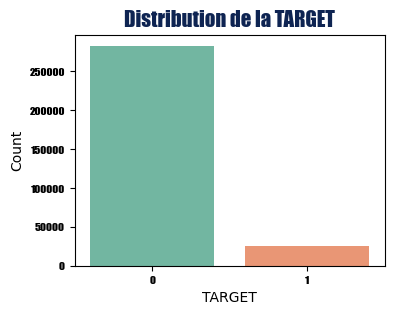

In [26]:
plt.figure(figsize=(4, 3))
sns.set_palette("Set2") 
sns.countplot(x='TARGET', data=app_train)
plt.xlabel('TARGET')
plt.ylabel('Count')
plt.xticks(fontsize=8,fontname="Impact")
plt.yticks(fontsize=8,fontname="Impact")
plt.title('Distribution de la TARGET', fontsize=15, weight="bold", fontname="Impact", color="#0e2452")
plt.show()

Ces informations montrent qu'il s'agit d'un problème de classe déséquilibrée :  il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. 

### 3.3.2 - Valeurs manquantes

In [27]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
                "There are " + str(mis_val_table_ren_columns.shape[0]) +
                  " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [28]:
# Statistiques des valeurs manquantes de l'app_train
missing_values = missing_values_table(app_train)
missing_values.head(20)


Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [29]:
missing_values.tail(20)

,Missing Values,% of Total Values
TOTALAREA_MODE,148431,48.3
EMERGENCYSTATE_MODE,145755,47.4
OCCUPATION_TYPE,96391,31.3
EXT_SOURCE_3,60965,19.8
AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.5
AMT_REQ_CREDIT_BUREAU_DAY,41519,13.5
AMT_REQ_CREDIT_BUREAU_MON,41519,13.5
AMT_REQ_CREDIT_BUREAU_QRT,41519,13.5
AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.5
AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.5


Lorsqu'il s'agira de construire nos modèles d'apprentissage automatique, nous devrons imputer ces valeurs manquantes. Dans un travail ultérieur, nous utiliserons des modèles tels que XGBoost ou LightGBM qui peuvent traiter les valeurs manquantes sans nécessiter d'imputation.
Une autre option consisterait à supprimer les colonnes présentant un pourcentage élevé de valeurs manquantes, bien qu'il soit impossible de savoir à l'avance si ces colonnes seront utiles à notre modèle. 
Par conséquent, nous conserverons toutes les colonnes pour l'instant.

### 3.3.3 - Type des colonnes

In [30]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [31]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques.

### 3.3.4 - Anomalies

Les anomalies dans les données sont un problème que nous devons toujours surveiller lorsque nous faisons de l'AED. Celles-ci peuvent être dues à des chiffres mal saisis, à des erreurs dans les mesures ou à des mesures valables mais extrêmes. L'une des façons de détecter les anomalies de manière quantitative est d'examiner les statistiques d'une colonne à l'aide de la méthode `describe`. 

In [32]:
pd.set_option('display.max_columns', None)

In [33]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

Les chiffres de la colonne `DAYS_BIRTH` sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une année :

In [34]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Ces âges semblent raisonnables. Il n'y a pas de valeurs aberrantes pour l'âge, que ce soit à l'extrémité supérieure ou inférieure. Qu'en est-il des jours d'emploi ? 

In [35]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Cela ne semble pas correct ! La valeur maximale (en plus d'être positive) est d'environ 1000 ans !

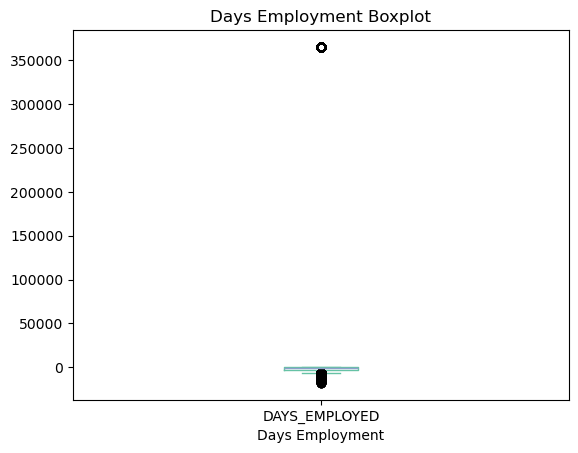

In [36]:
# Crée un boxplot pour la colonne 'DAYS_EMPLOYED'
app_train['DAYS_EMPLOYED'].plot.box(title='Days Employment Boxplot')

# Ajoute une étiquette à l'axe x
plt.xlabel('Days Employment')

# Affiche le graphique
plt.show()

Par simple curiosité, nous allons regrouper les clients présentant des anomalies et voir s'ils ont tendance à avoir des taux de défaillance plus élevés ou plus faibles que le reste des clients.

In [37]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Il s'avère que les anomalies ont un taux de défaillance plus faible. 

Le traitement des anomalies dépend de la situation exacte et il n'existe pas de règles fixes. L'une des approches les plus sûres consiste à définir les anomalies comme des valeurs manquantes et à les compléter (à l'aide de l'imputation) avant l'apprentissage automatique. Dans ce cas, comme toutes les anomalies ont exactement la même valeur, nous voulons les compléter avec la même valeur au cas où tous ces prêts auraient quelque chose en commun. Les valeurs anormales semblent avoir une certaine importance, c'est pourquoi nous voulons indiquer au modèle d'apprentissage automatique si nous avons effectivement renseigné ces valeurs. Comme solution, nous allons remplir les valeurs anormales avec un nombre (`np.nan`) et ensuite créer une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.



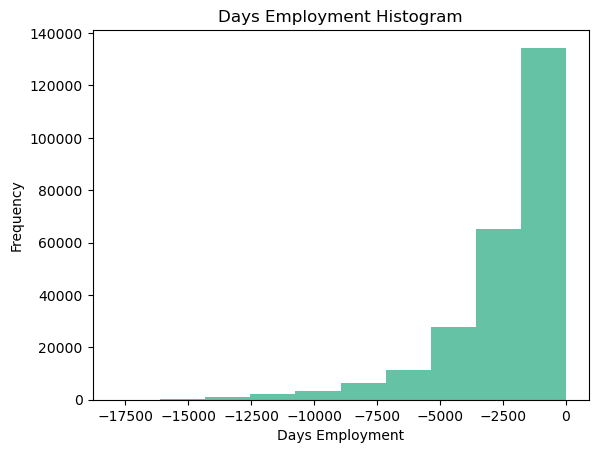

In [38]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Tout ce que nous faisons sur les données d'entraînement, nous devons également le faire sur les données de test. Veillons à créer la nouvelle colonne et à remplir la colonne existante avec np.nan dans les données de test.

In [39]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


La distribution semble beaucoup plus conforme à ce que nous attendons, et nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient à l'origine anormales (parce que nous devrons remplir les nans avec une valeur, probablement la médiane de la colonne). Les autres colonnes avec `DAYS` dans le cadre de données semblent être à peu près ce que nous attendons, sans valeurs aberrantes évidentes. 

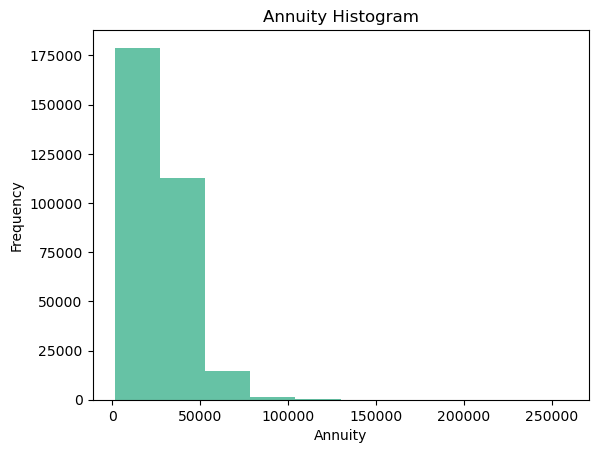

In [40]:
app_train['AMT_ANNUITY'].plot.hist(title = 'Annuity Histogram');
plt.xlabel('Annuity');

### 3.3.5 - Correlations

Une façon d'essayer de comprendre les données est de rechercher des corrélations entre les variables et la cible. Nous pouvons calculer le coefficient de corrélation de Pearson entre chaque variable et la cible à l'aide de la méthode .corr dataframe.

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la « pertinence » d'une caractéristique, mais il nous donne une idée des relations possibles entre les données. Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation :

* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”


In [23]:
numeric_columns=app_train.select_dtypes(include=np.number).columns.tolist()
numeric_columns

# Matrice de corrélation
correlations = app_train[numeric_columns].corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227


La corrélation `DAYS_BIRTH` est la plus positive. En regardant la documentation, `DAYS_BIRTH` est l'âge en jours du client au moment du prêt en jours négatifs. La corrélation est positive, mais la valeur de cette caractéristique est en fait négative, ce qui signifie que plus le client vieillit, moins il est susceptible de ne pas rembourser son prêt (c'est-à-dire la cible == 0). C'est un peu déroutant, nous prendrons donc la valeur absolue de la caractéristique et la corrélation sera négative.

#### 3.3.5.1 - Effet de l'âge sur le remboursement

In [24]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

Plus le client est âgé, plus il existe une relation linéaire négative avec la cible, ce qui signifie que plus les clients sont âgés, plus ils ont tendance à rembourser leurs prêts à temps. 

Commençons par examiner cette variable. Tout d'abord, nous pouvons faire un histogramme de l'âge. L'axe des x sera exprimé en années pour rendre le graphique un peu plus compréhensible.

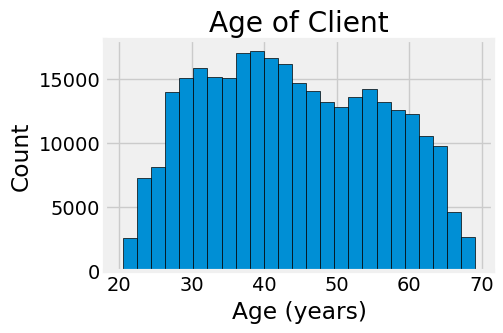

In [25]:
# Set the style of plots
plt.figure(figsize=(5,3))
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

En soi, la distribution de l'âge ne nous apprend pas grand-chose, si ce n'est qu'il n'y a pas de valeurs aberrantes puisque tous les âges sont raisonnables.
Pour visualiser l'effet de l'âge sur la cible, nous ferons ensuite un graphique d'estimation de la densité du noyau (KDE) coloré par la valeur de la cible. Un graphique d'estimation de la densité du noyau montre la distribution d'une seule variable et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement une gaussienne, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer une seule courbe lisse). Nous utiliserons le `kdeplot` de seaborn pour ce graphique.

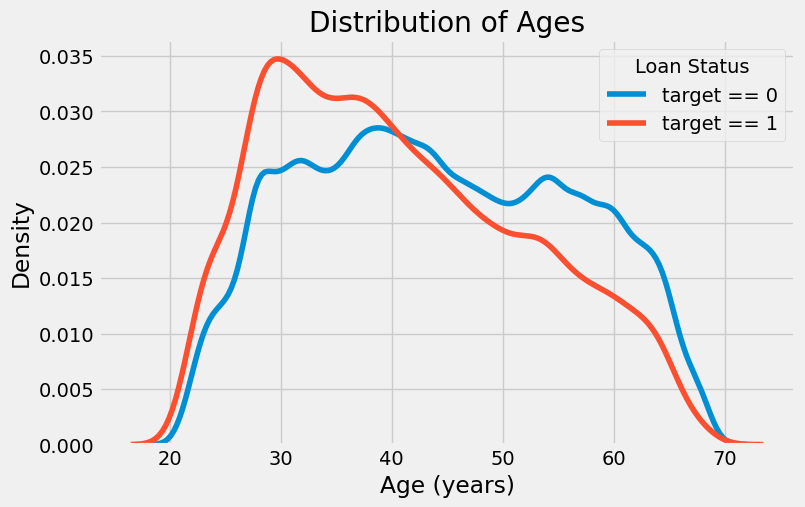

In [26]:
plt.figure(figsize=(8, 5))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label='target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label='target == 1')


plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')


plt.legend(title='Loan Status')
plt.show()

La courbe de la Target == 1 penche vers l'extrémité la plus jeune de la fourchette. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Examinons cette relation sous un autre angle : le taux moyen de non-remboursement des prêts par tranche d'âge. 

Pour créer ce graphique, nous commençons par « découper » la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque tranche, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge.

In [27]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [28]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


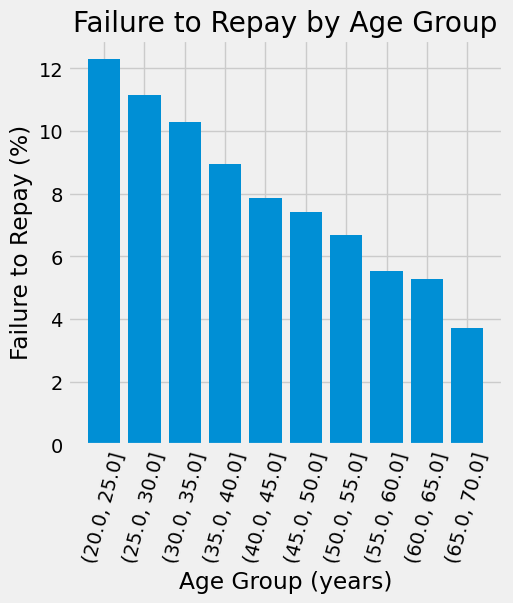

In [29]:
plt.figure(figsize = (5, 5))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

La tendance est claire : les jeunes demandeurs sont plus susceptibles de ne pas rembourser le prêt ! Le taux de non-remboursement est supérieur à 10 % pour les trois groupes d'âge les plus jeunes et inférieur à 5 % pour le groupe le plus âgé.

Il s'agit d'une information qui pourrait être directement utilisée par la banque : étant donné que les jeunes clients sont moins susceptibles de rembourser le prêt, il conviendrait peut-être de leur fournir davantage de conseils ou d'astuces en matière de planification financière. Cela ne signifie pas que la banque doive discriminer les jeunes clients, mais il serait judicieux de prendre des mesures de précaution pour les aider à rembourser à temps.

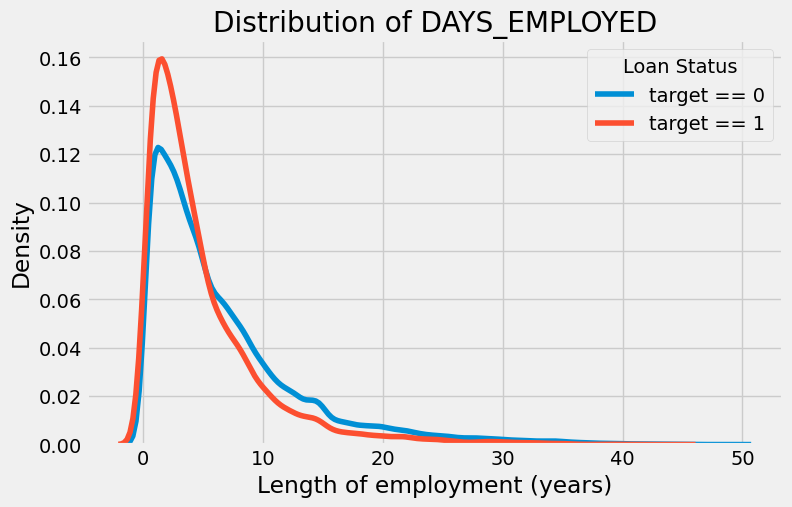

In [30]:
plt.figure(figsize=(8, 5))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_EMPLOYED'] / -365, label='target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_EMPLOYED'] / -365, label='target == 1')


plt.xlabel('Length of employment (years)')
plt.ylabel('Density')
plt.title('Distribution of DAYS_EMPLOYED')


plt.legend(title='Loan Status')
plt.show()

#### 3.3.5.2 - Sources Extérieures

Les 3 variables ayant les corrélations négatives les plus fortes avec la cible sont `EXT_SOURCE_1`, `EXT_SOURCE_2`, et `EXT_SOURCE_3`.
Selon la documentation, ces caractéristiques représentent un « score normalisé de la source de données externe ». Il est difficile de comprendre ce que cela signifie exactement, mais il pourrait s'agir d'une sorte d'évaluation de crédit cumulative réalisée à partir de nombreuses sources de données. 

Examinons ces variables.

Tout d'abord, nous pouvons montrer les corrélations des caractéristiques `EXT_SOURCE` avec la cible et entre elles.

In [31]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


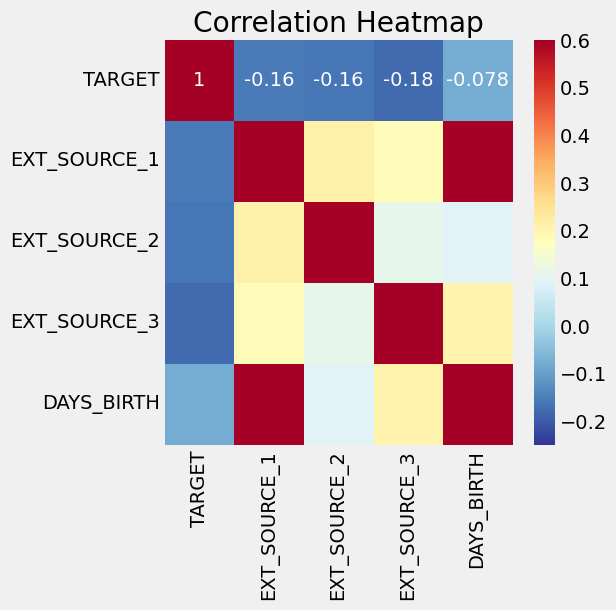

In [32]:
plt.figure(figsize = (5, 5))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de l'EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également constater que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, ce qui indique que l'âge du client est peut-être l'un des facteurs de ce score.

Nous pouvons ensuite examiner la distribution de chacune de ces caractéristiques en fonction de la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

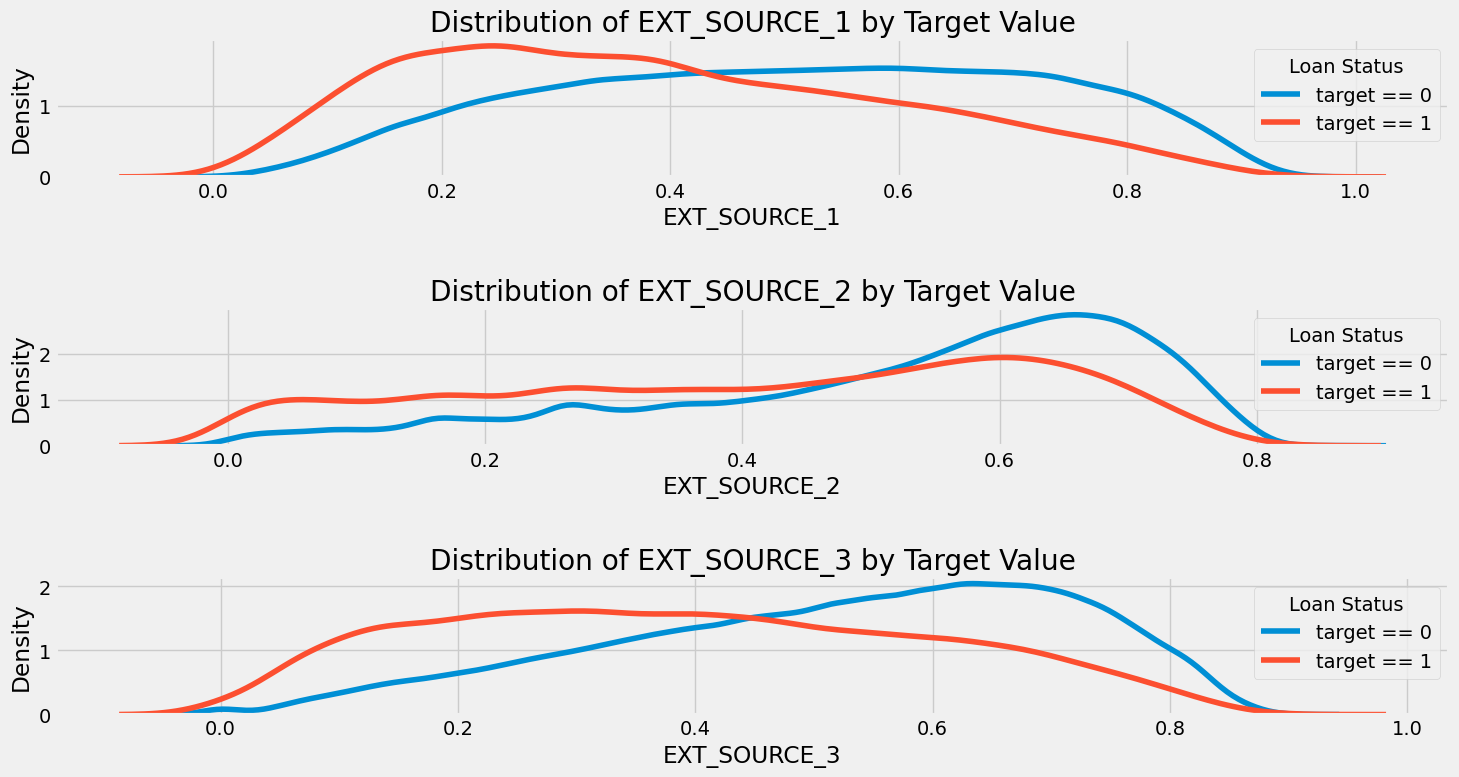

In [33]:
plt.figure(figsize=(15, 8))


for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    plt.subplot(3, 1, i + 1)
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label='target == 0')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label='target == 1')
    

    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Density')
    

    plt.legend(title='Loan Status')

plt.tight_layout(h_pad=2.5)
plt.show()
    

`EXT_SOURCE_3` affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte (en fait, elles sont toutes considérées comme très faibles, mais ces variables seront toujours utiles pour un modèle d'apprentissage automatique permettant de prédire si un demandeur remboursera ou non un prêt dans les délais.

In [34]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

In [35]:
app_train_domain.to_csv('app_train_domain.csv', index=False)
app_test_domain.to_csv('app_test_domain.csv', index=False)


# 4 - Modélisation

In [36]:
# démarrage du tracking
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

### 4.1 - Split train en train/test

Je garde une copie du df intact avec les id clients et la target

In [37]:
app_train_origin=app_train_domain.copy()

In [38]:
ID = app_train_domain['SK_ID_CURR'] 
X = app_train_domain.drop(['SK_ID_CURR','TARGET'], axis=1)  
y = app_train_domain['TARGET']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 4.2 - Encoding Variables catégorielles

Un modèle d'apprentissage automatique ne peut pas traiter les variables catégorielles (à l'exception de certains modèles tels que LightGBM : http://lightgbm.readthedocs.io/en/latest/Features.html). 

Nous devons donc trouver un moyen d'encoder (représenter) ces variables sous forme de nombres avant de les transmettre au modèle. Il y a deux façons principales d'effectuer ce processus :
- Label encoding: attribue un nombre entier à chaque catégorie unique d'une variable catégorielle.
- One-hot encoding: créé une nouvelle colonne pour chaque catégorie unique dans une variable catégorielle. Chaque observation reçoit un 1 dans la colonne de la catégorie correspondante et un 0 dans toutes les autres nouvelles colonnes.

Le problème du Label encoding est qu'il donne aux catégories un ordre arbitraire. La valeur attribuée à chacune des catégories est aléatoire et ne reflète aucun aspect inhérent à la catégorie. Dans l'exemple ci-dessus, le programmeur reçoit un 4 et le scientifique des données un 1, mais si nous refaisions le même processus, les étiquettes pourraient être inversées ou complètement différentes. L'affectation réelle des nombres entiers est arbitraire. Par conséquent, lorsque nous procédons à l'encodage des étiquettes, le modèle peut utiliser la valeur relative de la caractéristique (par exemple, programmeur = 4 et scientifique = 1) pour attribuer des poids, ce qui n'est pas ce que nous voulons. Si nous n'avons que deux valeurs uniques pour une variable catégorielle (telle que Homme/Femme), le Label Encoding convient, mais pour plus de deux catégories uniques, le One Hot Encoding est l'option la plus sûre.

Le seul inconvénient du One Hot Encoding est que le nombre de caractéristiques (dimensions des données) peut exploser avec des variables catégorielles comportant de nombreuses catégories. Pour y remédier, nous pouvons effectuer un OHE suivi d'une ACP ou d'autres méthodes de réduction de la dimensionnalité afin de réduire le nombre de dimensions tout en essayant de préserver l'information. 

Dans ce NB, nous utiliserons le Label Encoding pour toutes les variables catégorielles comportant seulement deux catégories et le OHE pour toutes les variables catégorielles comportant plus de deux catégories. Il se peut que ce processus doive être modifié au fur et à mesure que nous avançons dans le projet, mais pour l'instant, nous allons voir où cela nous mène. 

In [39]:
# Create a label encoder object
le = LabelEncoder()

# Iterate through the columns
le = LabelEncoder()
for col in X_train.columns:
    if X_train[col].dtype == 'object' and len(list(X_train[col].unique())) <= 2:
        # Apply the label encoder to both training and test sets
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])


In [40]:
print('Training Features shape: ', X_train.shape)
print('Test Features shape: ', X_test.shape)

Training Features shape:  (246008, 121)
Test Features shape:  (61503, 121)


In [41]:
# Prétraitement : One-Hot Encoding pour les variables catégorielles
X_train_ohe = pd.get_dummies(X_train)
X_test_ohe = pd.get_dummies(X_test)

print('Training Features shape: ', X_train_ohe.shape)
print('Test Features shape: ', X_test_ohe.shape)


Training Features shape:  (246008, 242)
Test Features shape:  (61503, 242)


Il doit y avoir les mêmes colonnes dans le train et dans le test. Si le OHE a créé plus de colonnes dans le train que dans le test (parce qu'il y avait des variables catégorielles dont les catégories n'étaient pas représentées dans les données de test), alors il faut supprimer les colonnes des données d'apprentissage qui ne se trouvent pas dans les données de test. Pour ça, nous devons « aligner » les cadres de données. 

In [42]:
# Assurons-nous que X_train et X_test ont les mêmes colonnes
X_train_ohe, X_test_ohe = X_train_ohe.align(X_test_ohe, join='inner', axis=1)

print('Training Features shape: ', X_train_ohe.shape)
print('Val Features shape: ', X_test_ohe.shape)


Training Features shape:  (246008, 242)
Val Features shape:  (61503, 242)


Rmq : Lorsqu'on utilise la méthode align() avec l'option join='inner' pour aligner deux DataFrames pandas sur l'axe des colonnes, toutes les colonnes qui ne sont pas communes aux deux DataFrames sont supprimées du résultat final. Cela signifie que toute information contenue dans ces colonnes supprimées est perdue dans les DataFrames retournés par la méthode.

## 4.3 - Imputation MV et normalisation avec un min max scaler

In [43]:
from sklearn.preprocessing import MinMaxScaler

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))


X_train_imp = pd.DataFrame(imputer.fit_transform(X_train_ohe), columns=X_train_ohe.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test_ohe), columns=X_test_ohe.columns)
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train_imp.columns)
X_test_sc = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test_imp.columns)



print('Training data shape: ', X_train_sc.shape)
print('Testing data shape: ', X_test_sc.shape)


Training data shape:  (246008, 242)
Testing data shape:  (61503, 242)


In [44]:
X_train_sc.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business

## 4.4 - Baseline = Dummy Classifier

Pour obtenir une baseline :
- nous utiliserons toutes les caractéristiques après avoir encodé les variables catégorielles.
- Nous allons prétraiter les données en remplissant les valeurs manquantes (imputation)
- et normaliser les caractéristiques.


### 4.4.1 - Entrainement et prédictions

Pour avoir une référence et, comme le jeu de données est déséquilibré, on va tester un modèle naïf avec la stratégie 'stratified', qui va générer des prédictions en respectant la distribution des classes de l'ensemble d'entrainement

In [45]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)

# Entraînement du Dummy Classifier
start_time=time.time()

dummy_clf.fit(X_train_sc, y_train)

end_time = time.time()
training_execution_time = round(end_time - start_time, 2)
print(f"Le temps d'entrainement est de {training_execution_time} secondes.")

Le temps d'entrainement est de 0.01 secondes.


Maintenant que le modèle a été entraîné, nous pouvons l'utiliser pour faire des prédictions. Nous voulons prédire les probabilités de ne pas rembourser un prêt, nous utilisons donc la méthode `predict.proba` du modèle. Celle-ci renvoie un tableau m x 2 où m est le nombre d'observations. La première colonne est la probabilité que la cible soit 0 et la deuxième colonne est la probabilité que la cible soit 1 (donc pour une seule ligne, la somme des deux colonnes doit être égale à 1). Nous voulons connaître la probabilité que le prêt ne soit pas remboursé, nous sélectionnerons donc la deuxième colonne.

Le code suivant effectue les prédictions et sélectionne la colonne correcte.

In [46]:
# Prédictions 
start_time=time.time()

y_pred_dummy_train = dummy_clf.predict(X_train_sc)
dummy_pred_train = dummy_clf.predict_proba(X_train_sc)[:, 1]

end_time = time.time()
predicting_execution_time = round(end_time - start_time, 2)
print(f"Le temps de prédiction sur le train est de {predicting_execution_time} secondes.")

y_pred_dummy_test = dummy_clf.predict(X_test_sc)
dummy_pred_test = dummy_clf.predict_proba(X_test_sc)[:, 1]


Le temps de prédiction sur le train est de 0.03 secondes.


### 4.4.2 - Evaluation

#### 4.4.2.1 - Confusion matrix et Classification Reports

In [47]:
pd.crosstab(y_test, y_pred_dummy_test, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,0,1
Classes réelles,,
0,52008,4546
1,4576,373


In [48]:
print(classification_report(y_test, y_pred_dummy_test))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     56554
           1       0.08      0.08      0.08      4949

    accuracy                           0.85     61503
   macro avg       0.50      0.50      0.50     61503
weighted avg       0.85      0.85      0.85     61503



Ce modèle naïf, bien qu'ayant une très bonne accuracy globale (85%), se révèle être très peu performant sur la classe minoritaire (1) avec un f1 score de 0.08. Regardons dans le détail :

**- Précision de 0.08 sur la classe 1** :  ratio du nombre de vrais positifs (TP) sur le total des prédictions positives (TP + FP) pour cette classe. Une précision de 0.08 signifie que parmi toutes les instances que le modèle a prédites comme appartenant à la classe 1, seulement 8% étaient réellement de la classe 1. En d'autres termes, **92% des prédictions positives pour la classe 1 étaient des faux positifs (FP)**.  

**- Rappel (Recall) de 0.08 sur la classe 1** : ratio du nombre de vrais positifs (TP) sur le total des instances réelles de la classe 1 (TP + FN). Un rappel de 0.08 signifie que le modèle n'a identifié correctement que 8% des instances réelles de la classe 1. En d'autres termes, **92% des instances réelles de la classe 1 ont été classées à tort comme appartenant à la classe 0 (FN).**



#### 4.4.2.2 - AUC du train et du test

La courbe ROC est un graphe qui trace le taux de vrais positifs (True Positive Rate, ou TPR) contre le taux de faux positifs (False Positive Rate, ou FPR) à différents seuils de décision. L'AUC est l'aire sous la courbe ROC. Elle mesure la capacité du modèle à distinguer entre les classes positives et négatives. Une AUC de 0.5 signifie que le modèle a une performance équivalente à une prédiction aléatoire. Une AUC de 1.0 signifie que le modèle est parfait pour distinguer entre les classes positives et négatives. Contrairement à des métriques comme la précision ou le rappel, qui dépendent d'un seuil de décision spécifique, l'AUC évalue la performance du modèle sur tous les seuils possibles. Cela en fait une mesure plus robuste et globale de la performance du modèle.

In [49]:
# Calculer l'AUC sur le train
auc_train = round(roc_auc_score(y_train, dummy_pred_train),2)
print("Train AUC:", auc_train)

Train AUC: 0.5


In [50]:
# Calculer l'AUC sur le test
auc_test = round(roc_auc_score(y_test, dummy_pred_test),2)
print("Test AUC:", auc_test)

Test AUC: 0.5


Ce modèle naïf a une performance équivalente à une prédiction aléatoire. Il va nous servir de base de travail.

Avant de le comparer à d'autres modèles plus performants, nous allons élaborer le score métier tenant compte du déséquilibre entre les bons et moins bons clients

### 4.4.3 - Elaboration du score métier

#### 4.4.3.1 - Définition de la matrice de coûts

Le déséquilibre entre le nombre de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent. Nous allons attribuer un coût métier 10 fois plus élevé pour un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) que pour un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge)

- Faux Négatif (FN) : un mauvais client est prédit comme bon. Fixons ce coût à 10.
- Faux Positif (FP) : un bon client est prédit comme mauvais. Fixons ce coût à 1.

#### 4.4.3.2 - Calcul du coût total des erreurs

On construit une fonction qui va calculer, pour chaque seuil de probabilité p utilisé pour classifier les observations en positives (clients défaillants) ou négatives (bons clients), le coût total des erreurs comme suit :
- on va calculer le nombre de FN et FP pour le seuil p
- on va calculer le coût total : coût total (p) = coût FN x Nbre FN + Coût FP x Nbre FP

In [51]:
def calculate_cost_threshold(y_true, probas, threshold, cost_fn, cost_fp):
    """
    Calcule le coût personnalisé pour un seuil donné dans une classification binaire en utilisant les coûts
    des faux négatifs et des faux positifs.

    Paramètres :
    -----------
    y_true : array-like
        Vecteur des étiquettes vraies (0 ou 1).
    
    probas : array-like
        Vecteur des probabilités prédites par le modèle pour la classe positive (1).
    
    threshold : float
        Seuil de probabilité utilisé pour convertir les probabilités en étiquettes binaires.
    
    cost_fn : float
        Coût associé à un faux négatif (FN).
    
    cost_fp : float
        Coût associé à un faux positif (FP).

    Retourne :
    --------
    cost : float
        Le coût total calculé en utilisant le nombre de faux négatifs et faux positifs et leurs coûts respectifs.

    Description :
    ------------
    La fonction transforme les probabilités prédites en étiquettes binaires en utilisant un seuil donné. 
    Les probabilités supérieures ou égales au seuil sont marquées comme positives (1), sinon comme négatives (0).
    Elle calcule ensuite les valeurs de la matrice de confusion (TN, FP, FN, TP) et renvoie le coût total basé sur
    les coûts fournis pour les faux négatifs et les faux positifs.

    
    """
    y_pred = (probas >= threshold).astype(int)  # transforme les probas en prédictions binaires en utilisant un seuil.
                                                # Les probabilités >= au seuil sont marquées comme 1 (positives),
                                                # les autres comme 0 (négatives).

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()  # .ravel() convertit la matrice 2x2 en un tableau à une dimension [tn, fp, fn, tp]
                                                               # permet une extraction facile de chaque valeur
    return cost_fn * fn + cost_fp * fp


#### 4.4.3.3 - Optimisation du seuil

Il va s'agir d'utiliser une méthode pour trouver le seuil p qui minimise le Cout total.  

In [52]:
thresholds = np.linspace(0, 1, 100) # génére 100 valeurs de seuil uniformément réparties entre 0 et 1

costs = [calculate_cost_threshold(y_test, dummy_pred_test, thr, cost_fn=10, cost_fp=1) for thr in thresholds]


In [53]:
# On cherche le seuil qui minimise le coût
optimal_threshold = round(thresholds[np.argmin(costs)],2) # détermine le seuil optimal en trouvant l'indice du coût minimal 
                                                        # dans la liste costs à l'aide de np.argmin(), 
                                                        # puis en récupérant la valeur correspondante dans thresholds. La valeur est arrondie à 2 décimales pour plus de lisibilité.
print(f"Optimal Threshold: {optimal_threshold}")

Optimal Threshold: 0.01


Ici, le seuil qui mnimise le coût métier est 0.01

### 4.4.4 - Analyse des résultats du test au seuil optimal

Nous faisons ici une nouvelle matrice de confusion et de nouvelles mesures de performances pour ce seuil optimal 

#### 4.4.4.1 - Confusion matrix et Classification Reports au seuil optimal

In [54]:
y_pred_optimal = (dummy_pred_test >= optimal_threshold).astype(int)

Rmq : (dummy_pred_test >= optimal_threshold) effectue une comparaison élément par élément entre les probabilités prédites et le seuil optimal. Cela crée un tableau de booléens où chaque élément est True si la probabilité prédite est supérieure ou égale au seuil optimal, sinon False.
.astype(int) est utilisé pour convertir les valeurs booléennes (True/False) en entiers (1/0). Ainsi, les valeurs supérieures ou égales au seuil optimal seront converties en 1 et les autres en 0.
Le résultat final, y_pred_optimal, est un tableau de prédictions binaires où chaque élément est 1 si la probabilité prédite correspondante est supérieure ou égale au seuil optimal, sinon 0.

In [55]:
pd.crosstab(y_test, y_pred_optimal, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,0,1
Classes réelles,,
0,52008,4546
1,4576,373


In [56]:
print(classification_report(y_test, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     56554
           1       0.08      0.08      0.08      4949

    accuracy                           0.85     61503
   macro avg       0.50      0.50      0.50     61503
weighted avg       0.85      0.85      0.85     61503



#### 4.4.4.2 - Récupération du recall et f1 score de la classe 1 + accuracy globale au seuil optimal

Pour enregistrer ces valeurs dans MLFlow

In [57]:
report = classification_report(y_test, y_pred_optimal, output_dict=True) # output_dict=True indique à la fonction classification_report 
                                                    # de renvoyer le rapport sous forme de dictionnaire Python plutôt que sous forme de chaîne de caractères.

In [58]:
report

{'0': {'precision': 0.9191290824261276,
  'recall': 0.9196166495738586,
  'f1-score': 0.919372801357634,
  'support': 56554.0},
 '1': {'precision': 0.07582842041065257,
  'recall': 0.07536876136593251,
  'f1-score': 0.07559789217673288,
  'support': 4949.0},
 'accuracy': 0.8516820317708079,
 'macro avg': {'precision': 0.49747875141839004,
  'recall': 0.49749270546989555,
  'f1-score': 0.4974853467671834,
  'support': 61503.0},
 'weighted avg': {'precision': 0.851270685659879,
  'recall': 0.8516820317708079,
  'f1-score': 0.8514762430509452,
  'support': 61503.0}}

In [59]:
recall_1_test = round(report['1']['recall'],2)
print(f"Recall for class '1': {recall_1_test}")

Recall for class '1': 0.08


In [60]:
f1_score_1_test = round(report['1']['f1-score'],2)
print(f"F1 Score for class '1': {f1_score_1_test}")

F1 Score for class '1': 0.08


In [61]:
accuracy_test = round(accuracy_score(y_test, y_pred_optimal),2)
print("Accuracy du test:", accuracy_test)

Accuracy du test: 0.85


### 4.4.5 - Enregistrement du modèle dans MLFlow

In [62]:
# Utilisation d'un échantillon de 10 lignes comme exemple d'entrée
input_example = X_train_sc.sample(n=10, random_state=42)

In [63]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     # mlflow.log_params(params)

#     # Log la métrique de perte que j'ai déclarée au dessus
    
#     mlflow.log_metric("optimal_threshold", optimal_threshold)

#     mlflow.log_metric("recall_1_test", recall_1_test)
#     mlflow.log_metric("f1_score_1_test", f1_score_1_test)
#     mlflow.log_metric("accuracy du test", accuracy_test)
    
#     mlflow.log_metric("auc_train", auc_train)
#     mlflow.log_metric("auc_test", auc_test)
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", predicting_execution_time)

    
    

#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "Dummy model _ Methode Stratified ")

#     # Infer the model signature
#     signature = infer_signature(X_train_sc, dummy_clf.predict(X_train_sc)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=dummy_clf, # le modèle
#         artifact_path="dummy_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=input_example, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-dummy", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )


Comparons maintenant notre modèle naïf à une régression logistique

## 4.5 - Régression logistique 

### 4.5.1 - Création de fonctions de scoring

In [64]:
def custom_f1(y_true, y_pred_proba):
    """
    Calcule le meilleur F1 score pour un modèle de classification binaire en sélectionnant le seuil
    de probabilité qui minimise un coût personnalisé basé sur les faux négatifs et les faux positifs.

    Paramètres :
    -----------
    y_true : array-like
        Vecteur des étiquettes vraies (0 ou 1).

    y_pred_proba : array-like
        Vecteur des probabilités prédites par le modèle pour la classe positive (1).

    Retourne :
    --------
    best_f1 : float
        Le meilleur F1 score obtenu en utilisant le seuil optimal.

    Description :
    ------------
    La fonction parcourt une gamme de seuils de probabilité (de 0 à 1) pour convertir les
    probabilités prédites en étiquettes binaires. Pour chaque seuil, elle calcule le F1 score et
    un coût défini comme suit :
        coût = (nombre de faux négatifs) * 10 + (nombre de faux positifs)
    Le meilleur F1 score est celui obtenu avec le seuil qui minimise ce coût.

    
    """
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_f1 = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_f1 = f1
            best_threshold = threshold
            best_cost = cost
    
    return best_f1


In [65]:
def custom_recall(y_true, y_pred_proba):
    """
    Calcule le rappel optimal pour une prédiction probabiliste en ajustant le seuil de classification.

    Cette fonction parcourt une gamme de seuils pour déterminer celui qui donne le meilleur rappel
    tout en minimisant un coût défini comme une combinaison des faux négatifs (fn) et des faux positifs (fp).
    Le coût est calculé comme suit : coût = fn * 10 + fp.

    Paramètres:
    y_true (array-like): Les vraies étiquettes de classe.
    y_pred_proba (array-like): Les probabilités prédites pour la classe positive.

    Retourne:
    float: Le meilleur rappel obtenu pour le seuil avec le coût le plus bas.
    """
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_recall = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_recall = recall
            best_threshold = threshold
            best_cost = cost
    
    return best_recall


### 4.5.2 - Entrainement

In [66]:
X_train_sc.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business

Création d'une fonction pour la recherche des hyperparamètres avec une grid search :

In [67]:
def run_grid_search(X_train, y_train, model, param_grid, fit_params=None, train_size=1.0):
    """
    Exécute une recherche en grille avec validation croisée pour optimiser les hyperparamètres d'un modèle de classification,
    en utilisant SMOTE pour équilibrer les classes et des scorers personnalisés.

    Paramètres :
    -----------
    X_train : array-like
        Les caractéristiques d'entraînement.
    
    y_train : array-like
        Les étiquettes d'entraînement.
    
    model : estimator
        Le modèle de classification à optimiser.
    
    param_grid : dict
        Dictionnaire des hyperparamètres à tester pour le modèle. Les clés doivent être les noms des hyperparamètres
        et les valeurs doivent être des listes de valeurs à tester.
    
    fit_params : dict, optionnel
        Paramètres supplémentaires à passer à la méthode `fit` du modèle.
    
    train_size : float, optionnel
        Fraction de l'ensemble d'entraînement à utiliser. La valeur par défaut est 1.0 (utiliser tout l'ensemble d'entraînement).

    Retourne :
    --------
    dict
        Un dictionnaire contenant les informations suivantes :
        - 'best_model' : le meilleur modèle estimé.
        - 'best_params_' : les meilleurs paramètres trouvés.
        - 'best_score_' : le meilleur score obtenu.
        - 'cv_results_' : les résultats détaillés de la validation croisée.

    Description :
    ------------
    Cette fonction effectue une recherche en grille avec validation croisée pour optimiser les hyperparamètres d'un modèle de classification.
    Elle utilise SMOTE pour équilibrer les classes et des scorers personnalisés pour évaluer les performances du modèle. Les scorers utilisés
    sont l'AUC, un F1 score personnalisé et un rappel personnalisé. Le pipeline de traitement comprend SMOTE pour le suréchantillonnage des
    classes minoritaires et le modèle à optimiser.

    
    """
    # Définir les scorers personnalisés
    scorers = {
        'AUC': 'roc_auc',
        'F1_opt': make_scorer(custom_f1, needs_proba=True),
        'recall_opt': make_scorer(custom_recall, needs_proba=True)
    }

    # Créer un pipeline avec SMOTE et le modèle
    pipeline = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('model', model)
    ])

    # Mettre à jour le param_grid pour correspondre au pipeline
    # Les paramètres du modèle doivent être préfixés par 'model__'
    param_grid = {f'model__{key}': value for key, value in param_grid.items()}

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=scorers,
        refit='AUC',
        cv=2,
        verbose=3,
        return_train_score=True
    )

    # Fractionnement des données si train_size < 1.0
    if train_size < 1.0:
        X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
        data_to_fit = (X_train_sample, y_train_sample)
    else:
        data_to_fit = (X_train, y_train)

    # Entraînement
    start_time = time.time()
    grid_search.fit(*data_to_fit)
    end_time = time.time()

    execution_time = round(end_time - start_time, 2)
    print(f"Le temps d'exécution est de {execution_time} secondes.")

    return {
        'best_model': grid_search.best_estimator_,
        'best_params_': grid_search.best_params_,
        'best_score_': grid_search.best_score_,
        'cv_results_': grid_search.cv_results_
    }


In [68]:
# Configuration du modèle
model_logit = LogisticRegression(
    solver='saga', 
    class_weight = 'balanced',
    random_state=42
)
model_logit

LogisticRegression(class_weight='balanced', random_state=42, solver='saga')

In [69]:
# Paramètres à passer au Grid Search
param_grid_logit = {
    'C': np.logspace(-4, 4, 2),
    'penalty': ['l1', 'l2']

}
param_grid_logit

{'C': array([1.e-04, 1.e+04]), 'penalty': ['l1', 'l2']}

Notes :  

1. **solver='saga'**
Le paramètre solver spécifie l'algorithme à utiliser pour l'optimisation des poids du modèle dans le processus d'apprentissage. saga est une variante de l'algorithme de descente de gradient stochastique qui est bien adaptée pour les grands jeux de données, car elle est efficace en termes de mémoire et supporte les deux types de régularisation L1 ((pour la sélection de caractéristiques) et L2 (pour éviter le surajustement)

2. **class_weight='balanced'** rééquilibre les classes en attribuant des poids inversement proportionnels à leurs fréquences dans les données d'entraînement. Autrement dit, les classes rares reçoivent des poids plus élevés, tandis que les classes fréquentes reçoivent des poids plus faibles. Les poids ajustés modifient la fonction de perte utilisée par le modèle, ce qui influence la direction des gradients lors de l'optimisation et aide le modèle à mieux apprendre les classes minoritaires.

3. **C** : contrôle la force de la régularisation. C'est l'inverse du terme de régularisation 𝜆, c'est-à-dire 
𝐶=1/𝜆.
Une valeur de C élevée (faible régularisation) permet au modèle de s'adapter davantage aux données d'entraînement, réduisant ainsi le biais mais augmentant le risque de surapprentissage (overfitting).
Une valeur de C faible (forte régularisation) restreint le modèle, ce qui peut aider à prévenir le surapprentissage en augmentant le biais mais réduisant la variance.

4. **penalty** : spécifie le type de régularisation à appliquer.
'l2' : Régularisation de type Ridge. Ajoute une pénalité proportionnelle au carré des coefficients (norme L2).
'l1' : Régularisation de type Lasso. Ajoute une pénalité proportionnelle à la valeur absolue des coefficients (norme L1), ce qui peut conduire à des coefficients exactement nuls, facilitant la sélection de caractéristiques.
'elasticnet' : Combine les régularisations L1 et L2, contrôlées par un autre hyperparamètre l1_ratio.



In [70]:
# Execution de la fonction
start_training_time = time.time()
results_logit = run_grid_search(X_train_sc, y_train, model_logit, param_grid_logit, train_size=1)
end_training_time = time.time()


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END model__C=0.0001, model__penalty=l1; AUC: (train=0.500, test=0.500) F1_opt: (train=0.000, test=0.000) recall_opt: (train=0.000, test=0.000) total time=   9.1s
[CV 2/2] END model__C=0.0001, model__penalty=l1; AUC: (train=0.500, test=0.500) F1_opt: (train=0.000, test=0.000) recall_opt: (train=0.000, test=0.000) total time=   8.9s
[CV 1/2] END model__C=0.0001, model__penalty=l2; AUC: (train=0.701, test=0.694) F1_opt: (train=0.231, test=0.236) recall_opt: (train=0.625, test=0.546) total time=  12.2s
[CV 2/2] END model__C=0.0001, model__penalty=l2; AUC: (train=0.700, test=0.703) F1_opt: (train=0.240, test=0.242) recall_opt: (train=0.547, test=0.553) total time=  11.9s
[CV 1/2] END model__C=10000.0, model__penalty=l1; AUC: (train=0.742, test=0.733) F1_opt: (train=0.259, test=0.253) recall_opt: (train=0.663, test=0.668) total time=  54.7s
[CV 2/2] END model__C=10000.0, model__penalty=l1; AUC: (train=0.740, test=0.734) F1_o

In [71]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

Le temps d'exécution est de 382.12 secondes.


In [72]:
# Extraction du meilleur modèle, meilleurs HP, meilleurs scores etc.

best_model_logit = results_logit['best_model']
best_params_logit = results_logit['best_params_']
best_score_logit = results_logit['best_score_']
cv_results_logit = results_logit['cv_results_']


print("Best Params:", best_params_logit)
print("Best AUC:", best_score_logit)


Best Params: {'model__C': 10000.0, 'model__penalty': 'l1'}
Best AUC: 0.7337142050475742


### 4.5.3 - Analyse de la cross_validation

Nous allons explorer ce qui se passe pour chacun des 2 folds de la cross validation

In [73]:
def extract_best_auc_result(results):
    """
    Extrait la meilleure configuration de modèle basée sur le score AUC à partir des résultats de validation croisée
    d'un GridSearchCV.

    Paramètres :
    -----------
    results : dict
        Un dictionnaire provenant de la fonction run_grid_search contenant 'cv_results_'.

    Retourne :
    --------
    DataFrame
        Un DataFrame contenant la ligne avec le meilleur score basé sur le classement AUC.

    Description :
    ------------
    Cette fonction convertit les résultats de validation croisée ('cv_results_') en un DataFrame,
    trie les résultats par le rang du score AUC (de manière ascendante), et retourne la meilleure
    configuration de modèle.

    Exemple :
    --------
    >>> results = run_grid_search(X_train, y_train, model, param_grid)
    >>> best_result = extract_best_auc_result(results)
    >>> print(best_result)
       param_model__C  mean_test_AUC  rank_test_AUC  ...
    0            1.0            0.85              1  ...

    """
    # Conversion des résultats de cv_results_ en DataFrame
    cv_results = results['cv_results_']
    df_cv_results = pd.DataFrame(cv_results)
    
    # Tri du DataFrame par le rang des scores AUC sur le jeu de test
    df_cv_results = df_cv_results.sort_values(by="rank_test_AUC", ascending=True)
    
    # Retour de la meilleure entrée
    return df_cv_results.head(1)


In [74]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [75]:
best_auc_result = extract_best_auc_result(results_logit)
best_auc_result.head(1)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__penalty,params,split0_test_AUC,split1_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,mean_train_AUC,std_train_AUC,split0_test_F1_opt,split1_test_F1_opt,mean_test_F1_opt,std_test_F1_opt,rank_test_F1_opt,split0_train_F1_opt,split1_train_F1_opt,mean_train_F1_opt,std_train_F1_opt,split0_test_recall_opt,split1_test_recall_opt,mean_test_recall_opt,std_test_recall_opt,rank_test_recall_opt,split0_train_recall_opt,split1_train_recall_opt,mean_train_recall_opt,std_train_recall_opt
2,49.901989,0.061675,4.7575,0.181377,10000.0,l1,"{'model__C': 10000.0, 'model__penalty': 'l1'}",0.733092,0.734336,0.733714,0.000622,1,0.742422,0.740419,0.741421,0.001001,0.25295,0.25729,0.25512,0.00217,1,0.259284,0.268385,0.263835,0.004551,0.667539,0.636144,0.651841,0.015697,1,0.663212,0.623365,0.643288,0.019924


La meilleure combinaison d'hyperparamètres est déterminée en maximisant l'AUC, grâce au paramètre refit='AUC' de GridSearchCV. Les autres métriques sont calculées pour fournir une évaluation complète des performances du modèle, mais elles ne sont pas utilisées pour le choix final des hyperparamètres.

In [76]:
# Les résultats de la combinaison la mieux classée
best_auc_result.iloc[0]

mean_fit_time                                                  49.901989
std_fit_time                                                    0.061675
mean_score_time                                                   4.7575
std_score_time                                                  0.181377
param_model__C                                                   10000.0
param_model__penalty                                                  l1
params                     {'model__C': 10000.0, 'model__penalty': 'l1'}
split0_test_AUC                                                 0.733092
split1_test_AUC                                                 0.734336
mean_test_AUC                                                   0.733714
std_test_AUC                                                    0.000622
rank_test_AUC                                                          1
split0_train_AUC                                                0.742422
split1_train_AUC                                   

On obtient une ligne par combinaison de variables :
- **'mean_fit_time'** et **'std_fit_time'** : Temps moyen et écart-type du temps d'ajustement, respectivement, à travers toutes les folds et les combinaisons de paramètres.  
- **'mean_score_time'** et **'std_score_time'** : Temps moyen et écart-type du temps d'évaluation, respectivement, à travers toutes les folds et les combinaisons de paramètres.
  
- **'param_C'** et **'param_penalty'** etc.. : Les valeurs des hyperparamètres pour chaque combinaison.  
- **'params'** : Liste de dictionnaires représentant les combinaisons de paramètres.
  
- **'split0_test_AUC'**, **'split1_test_AUC'**, ...,  : AUC du test pour chaque fold.  
- **'mean_test_AUC'** et **'std_test_AUC'** : Moyenne et écart-type des AUC à travers toutes les folds pour chaque combinaison de paramètres.  
- **'rank_test_AUC'** : Le classement de chaque combinaison de paramètres basé sur la moyenne des AUC.  


Etc...


=> Dans notre exemple, c'est la combinaison :
 {'model__C': 10000.0, 'model__penalty': 'l1'}
 qui a obtenu la meilleure AUC, comme indiqué par le rang 1 dans les deux cas.

In [77]:
def plot_auc_scores(best_auc_result):
    """
    Trace les scores AUC des différents plis de validation croisée pour la meilleure configuration de modèle basée sur le classement.

    Paramètres :
    -----------
    best_auc_result : DataFrame
        Un DataFrame contenant la meilleure ligne des résultats de validation croisée (cv_results_) triés par AUC.

    Description :
    ------------
    Cette fonction extrait les scores AUC pour chaque pli de validation croisée (train et test) pour la configuration
    de modèle ayant le meilleur classement AUC. Elle trace ensuite ces scores pour visualiser la performance du modèle
    sur les différents plis.

    Exemple :
    --------
    >>> best_result = extract_best_auc_result(results)
    >>> plot_auc_scores(best_result)

    """
    # Extraire les scores AUC pour chaque pli pour la meilleure configuration AUC
    df_train_results_auc = best_auc_result[[
        'split0_train_AUC', 
        'split1_train_AUC', 
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    df_test_results_auc = best_auc_result[[
        'split0_test_AUC', 
        'split1_test_AUC', 
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Tracer les scores de validation
    ax.plot(range(0, 2), df_test_results_auc.reshape(-1), label='Scores de validation')
    
    # Tracer les scores d'entraînement
    ax.plot(range(0, 2), df_train_results_auc.reshape(-1), label='Scores de train')

    # Définir les propriétés de l'axe
    ax.set_xticks(range(0, 2))
    ax.set_xlabel("Folds de cross-validation")
    ax.set_ylabel('AUC')
    ax.set_title("AUC de chaque fold \n pour la combinaison d'hyperparamètres \n qui arrive au rang 1 en terme d'AUC", fontsize=15, weight="bold", fontname="Impact", color="#0e2452")
    
    # Ajouter une légende
    ax.legend()

    fig.tight_layout()
    
    plt.show()


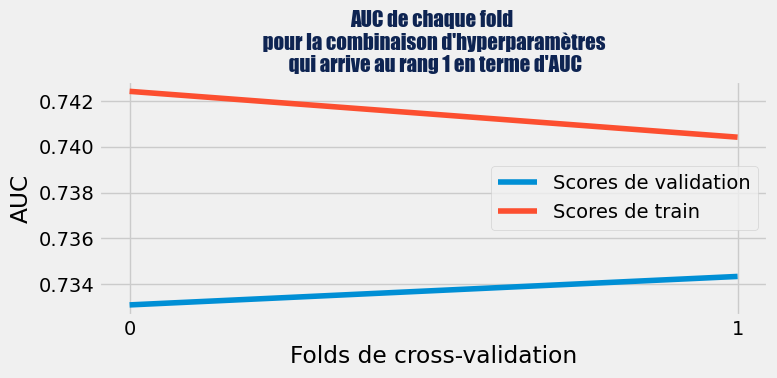

In [78]:
plot_auc_scores(best_auc_result)

Résultats proches d'un fold à l'autre

### 4.5.4 - Prédictions et métriques d'évaluation

Création d'une fonction qui va évaluer le modèle sur les données d'entrainement et sur les données de test, en calculant différetes métriques

In [79]:
def evaluate_model(X_train, y_train, X_test, y_test, best_model):
    """
    Évalue le modèle de classification sur les ensembles de données d'entraînement et de test,
    en calculant diverses métriques de performance et en déterminant le seuil optimal basé sur une fonction de coût.

    Paramètres :
    -----------
    X_train : array-like
        Les caractéristiques d'entraînement.
    
    y_train : array-like
        Les étiquettes d'entraînement.
    
    X_test : array-like
        Les caractéristiques de test.
    
    y_test : array-like
        Les étiquettes de test.
    
    best_model : estimator
        Le meilleur modèle estimé obtenu après la recherche en grille.

    Retourne :
    --------
    dict
        Un dictionnaire contenant les métriques suivantes :
        - 'predicting_execution_time' : le temps d'exécution pour les prédictions.
        - 'auc_train' : l'AUC sur les données d'entraînement.
        - 'auc_test' : l'AUC sur les données de test.
        - 'optimal_threshold' : le seuil optimal pour la fonction de coût.
        - 'f1_score_1_test' : le F1 score sur les données de test au seuil optimal.
        - 'recall_1_test' : le rappel sur les données de test au seuil optimal.
        - 'accuracy_test' : l'exactitude sur les données de test au seuil optimal.

    Description :
    ------------
    Cette fonction prédit les probabilités pour les ensembles de données d'entraînement et de test, 
    calcule l'AUC pour les deux ensembles, trouve le seuil optimal basé sur une fonction de coût personnalisée 
    (faux négatifs coûtant 10 unités et faux positifs coûtant 1 unité), et calcule les métriques de performance 
    (F1 score, rappel, exactitude) au seuil optimal.

    Exemple :
    --------
    >>> results = evaluate_model(X_train, y_train, X_test, y_test, best_model)
    >>> print(results['auc_test'])
    0.85

    """
    start_predict_time = time.time()
    # Prédire sur les données d'entraînement
    y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
    
    # Prédire sur les données de test
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    end_predict_time = time.time()

    # Calculer l'AUC pour les données d'entraînement et de test
    auc_train = round(roc_auc_score(y_train, y_train_pred_proba), 2)
    auc_test = round(roc_auc_score(y_test, y_test_pred_proba), 2)

    # Trouver le seuil optimal pour la fonction de coût sur les données d'entraînement
    thresholds = np.linspace(0, 1, 100)
    costs = [calculate_cost_threshold(y_test, y_test_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
    optimal_threshold = round(thresholds[np.argmin(costs)], 2) 

    # Métriques au seuil optimal
    y_test_pred_opt = (y_test_pred_proba >= optimal_threshold).astype(int)
    
    f1_score_1_test = f1_score(y_test, y_test_pred_opt)
    recall_1_test = recall_score(y_test, y_test_pred_opt)
    accuracy_test = accuracy_score(y_test, y_test_pred_opt)
    
    return {
        'predicting_execution_time': round(end_predict_time - start_predict_time, 2),
        'auc_train': auc_train,
        'auc_test': auc_test,
        'optimal_threshold': optimal_threshold,
        'f1_score_1_test': round(f1_score_1_test, 2),
        'recall_1_test': round(recall_1_test, 2),
        'accuracy_test': round(accuracy_test, 2)
    }


In [81]:
result_logit=evaluate_model (X_train_sc, y_train, X_test_sc, y_test, best_model_logit)
result_logit

{'predicting_execution_time': 0.12,
 'auc_train': 0.74,
 'auc_test': 0.74,
 'optimal_threshold': 0.51,
 'f1_score_1_test': 0.26,
 'recall_1_test': 0.64,
 'accuracy_test': 0.7}

- La RegLog performe bcp mieux que le modèle naïf, avec une AUC sur le train et sur le test de 0.74 => ce qui veut dire que le modèle a une bonne capacité discriminante. Il peut distinguer correctement les classes positives et négatives 74% du temps.
- Le fait que l'AUC soit similaire pour les données d'entraînement et de test suggère que le modèle généralise bien. Il n'y a pas de signe de surapprentissage (overfitting) ni de sous-apprentissage (underfitting).
- Le seuil optimal qui permet de minimiser le coût métier est de 0.51
- A ce seuil optimal de 0.51, le recall de la classe 1 monte à 0.64 => cela signifie que le modèle détecte correctement 64% des instances de la classe 1. Ce rappel est raisonnablement bon, mais il y a encore 36% des instances de la classe 1 qui ne sont pas détectées (faux négatifs).

### 4.5.5 - Enregistrement du modèle dans ML Flow

In [82]:

# Utiliser un échantillon de 10 lignes comme exemple d'entrée
input_example = X_train_sc.sample(n=10, random_state=42)


In [83]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     mlflow.log_params(best_params_logit)

#     # Log les métriques
    
#     mlflow.log_metric("optimal_threshold", result_logit['optimal_threshold'])

#     mlflow.log_metric("recall_1_test", result_logit['recall_1_test'])
#     mlflow.log_metric("f1_score_1_test", result_logit['f1_score_1_test'])
#     mlflow.log_metric("accuracy du test", result_logit['accuracy_test'])
    
#     mlflow.log_metric("auc_train", result_logit['auc_train'])
#     mlflow.log_metric("auc_test", result_logit['auc_test'])
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", result_logit['predicting_execution_time'])

      

#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "Logistic Regression with GridSearchCV ")

#     # Infer the model signature
#     signature = infer_signature(X_train_sc, best_model_logit.predict(X_train_sc)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=best_model_logit.named_steps['model'], # le modèle
#         artifact_path="logistic_regression_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=input_example, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-logistic-regression", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )


### 4.5.6 - Feature Importance

In [84]:
importances = best_model_logit.named_steps['model'].coef_
importances = importances.flatten()

In [85]:
feature_importances = pd.DataFrame({
    'feature': X_train_sc.columns, 
    'importance': importances
})

In [86]:
feature_importances_sorted=feature_importances.sort_values(by='importance', ascending=False).reset_index()
feature_importances_sorted=feature_importances_sorted.head(10)

In [87]:
feature_importances_sorted['importance_normalized'] = feature_importances_sorted['importance'] / feature_importances_sorted['importance'].sum()

In [88]:
feature_importances_sorted

,index,feature,importance,importance_normalized
0,5,AMT_CREDIT,10.635820,0.239954
1,77,DEF_30_CNT_SOCIAL_CIRCLE,5.560673,0.125454
2,51,COMMONAREA_MODE,5.109357,0.115272
3,81,FLAG_DOCUMENT_2,4.570375,0.103112
4,71,LIVINGAPARTMENTS_MEDI,3.818498,0.086149
5,62,BASEMENTAREA_MEDI,3.178713,0.071715
6,35,YEARS_BEGINEXPLUATATION_AVG,3.042854,0.068650
7,46,NONLIVINGAREA_AVG,2.874495,0.064851
8,120,NAME_INCOME_TYPE_Maternity leave,2.779584,0.062710
9,52,ELEVATORS_MODE,2.754067,0.062134


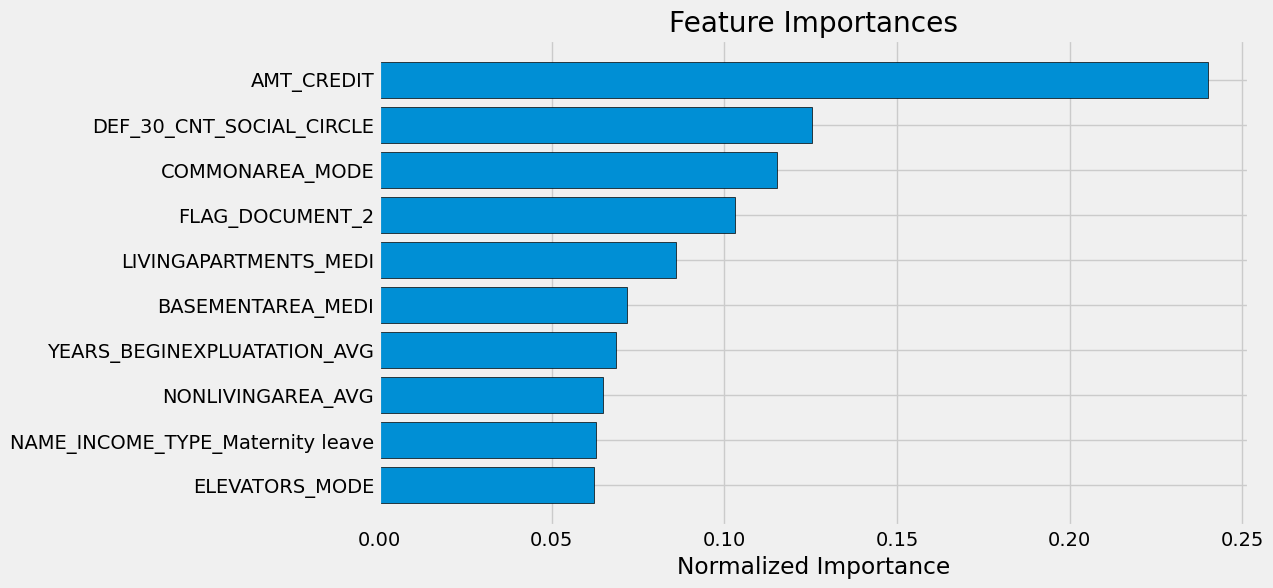

In [89]:
# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances_sorted.index[:15]))), 
feature_importances_sorted['importance_normalized'].head(15), 
align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances_sorted.index[:15]))))
ax.set_yticklabels(feature_importances_sorted['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

Les 3 premières variables les + importantes pour le modèle :
- 'AMT_CREDIT' =	Montant du prêt
- 'DEF_30_CNT_SOCIAL_CIRCLE' = nombre d'occasions où les entourages sociaux du client ont été enregistrés comme ayant un retard de paiement exactement de 30 jours après la date d'échéance.
- 'COMMONAREA_MODE' = Informations normalisées sur l'immeuble où vit le client : taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, surface commune, surface habitable, âge de l'immeuble, nombre d'ascenseurs, nombre d'entrées, état de l'immeuble, nombre d'étages, etc.


Nous allons maintenant comparer avec une random forest

## 4.6 - Random Forest

###  4.6.1 - Entrainement

In [90]:
model_RF = RandomForestClassifier(random_state = 50, 
                                  class_weight='balanced')
param_grid_RF = {
   'n_estimators': [120,150],  
   'max_depth': [7,8],
   # 'max_features': [0.0],
   # 'min_samples_leaf': [0.01,0.05],
   # 'min_samples_split': [0.03,0.05]
    
}

NOTES :
- **n_estimators** est le nombre d'arbres de décision que la forêt aléatoire va entraîner.
- **max_depth** est la profondeur maximale que chaque arbre de décision dans la forêt peut atteindre.

In [91]:
# Execution de la fonction
start_training_time = time.time()

results_RF = run_grid_search(X_train_sc, y_train, model_RF, param_grid_RF)

end_training_time = time.time()

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END model__max_depth=7, model__n_estimators=120; AUC: (train=0.678, test=0.667) F1_opt: (train=0.216, test=0.214) recall_opt: (train=0.622, test=0.580) total time=  41.0s
[CV 2/2] END model__max_depth=7, model__n_estimators=120; AUC: (train=0.680, test=0.659) F1_opt: (train=0.216, test=0.209) recall_opt: (train=0.639, test=0.546) total time=  39.0s
[CV 1/2] END model__max_depth=7, model__n_estimators=150; AUC: (train=0.679, test=0.668) F1_opt: (train=0.214, test=0.217) recall_opt: (train=0.657, test=0.546) total time=  47.3s
[CV 2/2] END model__max_depth=7, model__n_estimators=150; AUC: (train=0.679, test=0.659) F1_opt: (train=0.217, test=0.210) recall_opt: (train=0.608, test=0.517) total time=  47.0s
[CV 1/2] END model__max_depth=8, model__n_estimators=120; AUC: (train=0.691, test=0.670) F1_opt: (train=0.221, test=0.213) recall_opt: (train=0.646, test=0.622) total time=  43.2s
[CV 2/2] END model__max_depth=8, model__n

In [92]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

Le temps d'exécution est de 514.14 secondes.


In [93]:
best_model_RF = results_RF['best_model']
best_params_RF = results_RF['best_params_']
best_score_RF = results_RF['best_score_']
cv_results_RF = results_RF['cv_results_']

print("Best Params:", best_params_RF)
print("Best AUC:", best_score_RF)

Best Params: {'model__max_depth': 8, 'model__n_estimators': 150}
Best AUC: 0.6658718718108061


La meilleure AUC est obtenu avec 150 arbres d'une profondeur de 8

###  2.3.2 - Analyse de la cross_validation

In [94]:
best_auc_result_RF = extract_best_auc_result(results_RF)
best_auc_result_RF.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__n_estimators,params,split0_test_AUC,split1_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,mean_train_AUC,std_train_AUC,split0_test_F1_opt,split1_test_F1_opt,mean_test_F1_opt,std_test_F1_opt,rank_test_F1_opt,split0_train_F1_opt,split1_train_F1_opt,mean_train_F1_opt,std_train_F1_opt,split0_test_recall_opt,split1_test_recall_opt,mean_test_recall_opt,std_test_recall_opt,rank_test_recall_opt,split0_train_recall_opt,split1_train_recall_opt,mean_train_recall_opt,std_train_recall_opt
3,47.828755,0.725087,5.490954,0.054296,8,150,"{'model__max_depth': 8, 'model__n_estimators':...",0.670432,0.661312,0.665872,0.00456,1,0.690682,0.691043,0.690862,0.00018,0.213935,0.209778,0.211856,0.002078,3,0.220787,0.22354,0.222164,0.001376,0.591366,0.578788,0.585077,0.006289,1,0.64681,0.61451,0.63066,0.01615


In [95]:
# Les résultats de la combinaison la mieux classée
best_auc_result_RF.iloc[0]

mean_fit_time                                                        47.828755
std_fit_time                                                          0.725087
mean_score_time                                                       5.490954
std_score_time                                                        0.054296
param_model__max_depth                                                       8
param_model__n_estimators                                                  150
params                       {'model__max_depth': 8, 'model__n_estimators':...
split0_test_AUC                                                       0.670432
split1_test_AUC                                                       0.661312
mean_test_AUC                                                         0.665872
std_test_AUC                                                           0.00456
rank_test_AUC                                                                1
split0_train_AUC                                    

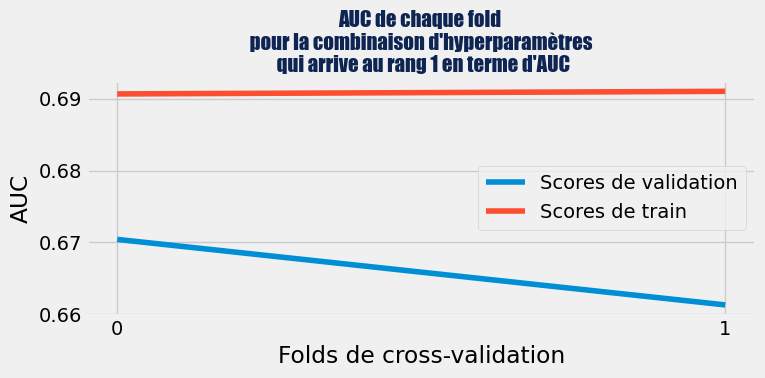

In [96]:
plot_auc_scores(best_auc_result_RF)

###  2.3.3 - Prédictions et métriques d'évaluation

In [97]:
result_RF=evaluate_model(X_train_sc, y_train, X_test_sc, y_test, best_model_RF)
result_RF

{'predicting_execution_time': 2.9,
 'auc_train': 0.68,
 'auc_test': 0.67,
 'optimal_threshold': 0.39,
 'f1_score_1_test': 0.21,
 'recall_1_test': 0.61,
 'accuracy_test': 0.63}

- Ces valeurs montrent que le RF a une performance raisonnable mais pas excellente. Une AUC autour de 0.67-0.68 indique que le modèle est capable de distinguer les classes positives et négatives environ 67-68% du temps (contre 74% avec la RegLog).
- Le fait que les AUC soient similaires pour l'entraînement et le test suggère que le modèle généralise bien et n'est pas surappris (overfitting).
- Le seuil optimal de 0.39 est celui qui minimise une fonction de coût spécifique (faux négatifs coûtant 10 unités et faux positifs coûtant 1 unité, comme indiqué dans la fonction calculate_cost_threshold)
- Un rappel de 0.61 signifie que le modèle détecte correctement 61% des instances de la classe 1.
Cela indique que le modèle rate encore 39% des instances positives (faux négatifs). Bien que ce rappel soit modérément bon, il y a encore une marge d'amélioration.

### 2.3.4 - Enregistrement dans ML Flow

In [98]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     mlflow.log_params(best_params_RF)

#     # Log les métriques
    
#     mlflow.log_metric("optimal_threshold", result_RF['optimal_threshold'])

#     mlflow.log_metric("recall_1_test", result_RF['recall_1_test'])
#     mlflow.log_metric("f1_score_1_test", result_RF['f1_score_1_test'])
#     mlflow.log_metric("accuracy du test", result_RF['accuracy_test'])
    
#     mlflow.log_metric("auc_train", result_RF['auc_train'])
#     mlflow.log_metric("auc_test", result_RF['auc_test'])
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", result_RF['predicting_execution_time'])

    
 
    

#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "Random forest Classifier with GridSearchCV ")

#     # Infer the model signature
#     signature = infer_signature(X_train_sc, best_model_RF.predict(X_train_sc)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=best_model_RF.named_steps['model'], # le modèle
#         artifact_path="random_forest_classifier_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=input_example, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-random-forest_classifier", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )


### 2.3.5 - Feature Importance

In [99]:
importances = best_model_RF.named_steps['model'].feature_importances_
features= X_train_sc.columns

In [100]:
def show_feature_importances(importances, features):
    """
    Affiche les importances des caractéristiques sous forme de graphique à barres horizontales
    et retourne les 10 caractéristiques les plus importantes triées par importance.

    Paramètres :
    -----------
    importances : array-like
        Les valeurs d'importance des caractéristiques. Elles doivent être de type numpy array ou similaire.
    
    features : array-like
        Les noms des caractéristiques correspondantes aux importances. Elles doivent être de type liste ou similaire.

    Retourne :
    --------
    DataFrame
        Un DataFrame contenant les 10 caractéristiques les plus importantes, leur importance brute et leur importance normalisée.

    Description :
    ------------
    Cette fonction crée un DataFrame des importances des caractéristiques et les trie par ordre décroissant d'importance.
    Elle sélectionne les 10 caractéristiques les plus importantes et normalise leurs importances. Ensuite, elle affiche
    un graphique à barres horizontales des importances normalisées pour ces 10 caractéristiques principales.

    Exemple :
    --------
    >>> importances = [0.15, 0.10, 0.05, 0.20, 0.50]
    >>> features = ['feature1', 'feature2', 'feature3', 'feature4', 'feature5']
    >>> feature_importances_sorted = show_feature_importances(importances, features)
    >>> print(feature_importances_sorted)
         feature  importance  importance_normalized
    0  feature5        0.50                   0.50
    1  feature4        0.20                   0.20
    2  feature1        0.15                   0.15
    3  feature2        0.10                   0.10
    4  feature3        0.05                   0.05

    """
    # Création du DataFrame
    importances = importances.flatten()
    
    feature_importances = pd.DataFrame({
        'feature': features, 
        'importance': importances
    })
    
    # Tri et sélection des 10 caractéristiques les plus importantes
    feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
    feature_importances_sorted = feature_importances_sorted.head(10)
    
    # Normalisation des importances
    feature_importances_sorted['importance_normalized'] = feature_importances_sorted['importance'] / feature_importances_sorted['importance'].sum()
    
    # Création du graphique à barres horizontales
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    
    # Inversion de l'index pour afficher la plus importante en haut
    indices = list(reversed(list(feature_importances_sorted.index)))
    ax.barh(indices, feature_importances_sorted['importance_normalized'], align='center', edgecolor='k')
    
    # Définition des étiquettes y
    ax.set_yticks(indices)
    ax.set_yticklabels(feature_importances_sorted['feature'])
    
    # Étiquetage du graphique
    plt.xlabel('Normalized Importance')
    plt.title('Top 10 Feature Importances')
    plt.show()
    
    return feature_importances_sorted


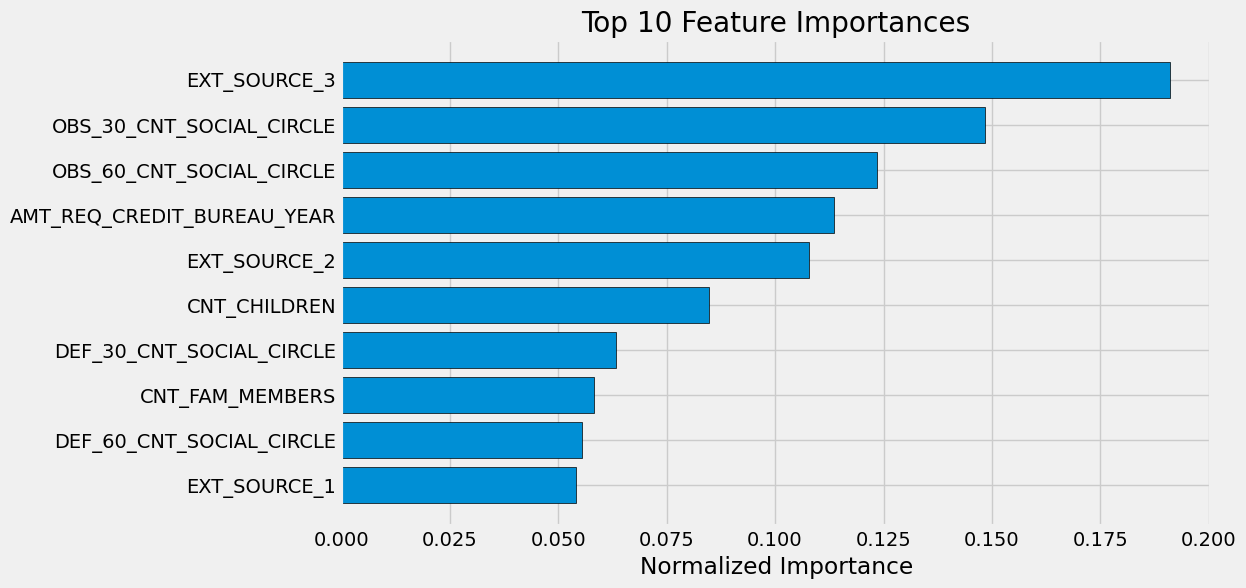

,feature,importance,importance_normalized
0,EXT_SOURCE_3,0.117288,0.190987
1,OBS_30_CNT_SOCIAL_CIRCLE,0.091057,0.148273
2,OBS_60_CNT_SOCIAL_CIRCLE,0.075811,0.123447
3,AMT_REQ_CREDIT_BUREAU_YEAR,0.069761,0.113597
4,EXT_SOURCE_2,0.066215,0.107822
5,CNT_CHILDREN,0.052067,0.084784
6,DEF_30_CNT_SOCIAL_CIRCLE,0.038883,0.063316
7,CNT_FAM_MEMBERS,0.035777,0.058257
8,DEF_60_CNT_SOCIAL_CIRCLE,0.034075,0.055486
9,EXT_SOURCE_1,0.033181,0.054031


In [101]:
show_feature_importances(importances, features)

Les 3 variables les + influentes :
- 'EXT_SOURCE_3' : variable de score normalisé provenant d'une source de données externe
- 'OBS_30_CNT_SOCIAL_CIRCLE' :  nombre d'observations où l'on peut constater que les entourages sociaux du client ont des défauts de paiement dépassant 30 jours après l'échéance prévue.
- - 'OBS_60_CNT_SOCIAL_CIRCLE' :  nombre d'observations où l'on peut constater que les entourages sociaux du client ont des défauts de paiement dépassant 60 jours après l'échéance prévue.

Les variables qui ont le plus de poids dans le Random Forest sont très différentes de la Regression logistique

## 4.7 - Light Gradient Boosting Machine

LightGBM est un framework d'apprentissage automatique développé par Microsoft, qui est largement utilisé pour les tâches de classification, de régression et de classement. Il appartient à la catégorie des algorithmes de boosting basés sur des arbres de décision, similaire à XGBoost et CatBoost.   

Voici quelques points clés pour comprendre LightGBM :

LightGBM utilise le gradient boosting, une technique qui construit de manière itérative des modèles de prévision en ajoutant des arbres de décision faibles, chaque nouvel arbre étant construit pour corriger les erreurs des arbres précédents. Ces arbres sont ajoutés séquentiellement jusqu'à ce qu'un nombre spécifié d'arbres soit atteint ou que les améliorations deviennent négligeables.

**Son fonctionnement** :
1. Initialisation 
- LightGBM commence par créer un modèle initial très simple, souvent appelé "base learner". Ce modèle peut être quelque chose d’aussi simple qu’une régression ou un arbre de décision très basique. L'idée est de créer un point de départ pour l'algorithme.
- Ce premier modèle fait une prédiction basique qui est généralement loin d'être parfaite mais fournit une base sur laquelle construire.

2. Apprendre des Erreurs
- Après avoir fait ses premières prédictions, LightGBM examine les erreurs — les différences entre les valeurs prédites et les valeurs réelles. Ces erreurs sont aussi appelées résidus.
- Un nouveau modèle est ensuite entraîné, mais au lieu de prédire la valeur cible originale, il essaie de prédire ces résidus (les erreurs du premier modèle). L’idée est de corriger là où le premier modèle s’est trompé.

3. Répéter
- Ce processus de correction des erreurs en entraînant un nouveau modèle sur les résidus est répété plusieurs fois. Chaque nouveau modèle est conçu pour améliorer les prédictions là où les modèles précédents ont échoué.
- À chaque étape, l’algorithme se concentre de plus en plus sur les cas les plus difficiles à prédire, raffinant progressivement sa capacité à modéliser les données de manière précise.

4. Combiner
- Tous les modèles simples créés lors des différentes itérations sont combinés pour former le modèle final. Chaque modèle individuel apporte sa contribution spécifique, aidant à prédire une partie différente du problème.
- Dans LightGBM, comme dans d'autres algorithmes de boosting, les contributions de chaque modèle peuvent être pondérées pour optimiser les performances globales. Certains modèles peuvent se voir attribuer plus d'importance en fonction de leur précision.

**Particularités du LightGBM**
- Contrairement à d'autres algorithmes qui construisent des arbres en se développant niveau par niveau, LightGBM utilise une stratégie de croissance par feuilles. Dans cette approche, plutôt que d'ajouter une rangée complète de branches, vous ajoutez la branche la plus nécessaire ou la plus "utile" à chaque étape, indépendamment du niveau. Cela permet de se concentrer plus intensément sur les parties de l'arbre qui réduiront le plus rapidement l'erreur globale. Cela permet souvent de réduire plus rapidement l'erreur globale, bien que le risque de surajustement puisse être légèrement plus élevé, surtout avec des ensembles de données plus petits.
- LightGBM utilise des techniques telles que le partage basé sur des histogrammes pour accélérer l'entraînement. Au lieu de regarder chaque point de donnée unique, il regroupe les valeurs en "bacs" (comme les barres d'un histogramme), et ces bacs sont utilisés pour trouver le meilleur endroit pour diviser les données. Cette méthode réduit considérablement le nombre de calculs nécessaires, car il y a moins de points de division à considérer. Cela rend l'algorithme beaucoup plus rapide et moins gourmand en mémoire, particulièrement avantageux quand on travaille avec de grands ensembles de données.

En résumé, LightGBB utilise une série de modèles qui apprennent progressivement des erreurs des modèles précédents, chacun ajoutant sa propre correction jusqu'à ce qu'un modèle final complet et précis soit formé. C'est une méthode puissante car elle transforme de nombreux apprenants faibles en un prédicteur fort et fiable.

**Avantages** :
- Vitesse et efficacité : L'une des principales forces de LightGBM est sa vitesse d'entraînement rapide et son utilisation efficace de la mémoire.
- Prise en charge des données catégorielles : LightGBM peut gérer directement les caractéristiques catégorielles sans nécessiter de codage préalable, ce qui est une différence significative par rapport à d'autres algorithmes de boosting.
- Facilité d'utilisation et flexibilité : Il est facile à configurer avec une large gamme de paramètres ajustables pour optimiser les performances du modèle.
  
**Applications** :
- LightGBM est utilisé dans une variété de domaines allant de la prédiction de risques financiers à la détection de fraudes, en passant par les recommandations de produits et la prédiction de demandes. Sa capacité à fournir des résultats rapides et précis avec des ensembles de données volumineux le rend particulièrement précieux dans les environnements où les performances et la vitesse sont critiques.



**Quelle différence avec XGboost ?**
LightGBM et XGBoost sont deux des frameworks les plus populaires pour le boosting d'arbres de décision, mais ils présentent des différences clés en termes de méthodologie, d'optimisation, et d'applications typiques. Voici une comparaison des deux, ainsi que les détails sur leur apparition :

XGBoost (eXtreme Gradient Boosting)
Apparition: XGBoost a été développé par Tianqi Chen dans le cadre d'un projet de recherche à l'Université de Washington et a été rendu public en 2014. Il a rapidement gagné en popularité en raison de sa performance dans de nombreuses compétitions de machine learning.

Caractéristiques:
- Utilise un modèle de boosting de gradient, construisant des arbres de manière séquentielle.
- Employe un algorithme basé sur le pré-partitionnement des données en structure de bloc pour gérer les grands ensembles de données de manière plus efficace.
- Propose des régularisations (L1 et L2) pour prévenir le surajustement.
- Utilise la croissance par niveaux des arbres (level-wise), qui équilibre mieux la croissance des arbres mais peut être moins efficace en termes de réduction de l'erreur par rapport à la croissance par feuilles.

LightGBM
Apparition: LightGBM a été développé par Microsoft et introduit en janvier 2017. Il a été conçu pour surmonter certaines des limitations de vitesse et d'échelle de XGBoost et d'autres algorithmes de boosting.

Caractéristiques:
- Utilise également le boosting de gradient mais incorpore plusieurs optimisations pour la vitesse et l'efficacité, comme le partage basé sur des histogrammes.
- Utilise la croissance par feuilles (leaf-wise) qui peut réduire l'erreur plus rapidement mais risque le surajustement sur des petits ensembles de données.
- Gère efficacement les données catégorielles sans prétraitement.
- Optimisé pour la performance en vitesse et en utilisation de mémoire, particulièrement sur des ensembles de données de grande taille.

Différences Clés
- Méthode de construction des arbres : XGBoost construit les arbres niveau par niveau tandis que LightGBM le fait feuille par feuille.
- Gestion des caractéristiques catégorielles : LightGBM peut gérer directement les caractéristiques catégorielles, alors que XGBoost nécessite généralement un prétraitement comme le one-hot encoding.
- Efficacité et vitesse : LightGBM est généralement plus rapide qu'XGBoost, en particulier sur des ensembles de données très grands ou avec de nombreuses caractéristiques, en raison de ses optimisations spécifiques.

Choix entre les deux
Le choix entre XGBoost et LightGBM dépend souvent de la taille de l'ensemble de données et des ressources disponibles :
- XGBoost peut être préférable pour des ensembles de données de taille modérée ou lorsque la prévention du surajustement est critique.
- LightGBM est souvent le choix pour des ensembles de données très volumineux ou pour des applications nécessitant une grande efficacité de calcul.

Dans l'ensemble, les deux frameworks sont hautement performants et le choix entre eux peut aussi dépendre de la familiarité et des préférences personnelles des utilisateurs en matière d'outils d'apprentissage automatique.

### 4.7.1 - Entrainement

In [102]:
model_LGBM = lgb.LGBMClassifier(objective='binary', # spécifie que le modèle est utilisé pour une classification binaire
                                boosting_type = 'goss',# boosting_type détermine l'algorithme de boosting à utiliser. 
                                                   # GOSS signifie Gradient-based One-Side Sampling. 
                                                   # GOSS est une méthode avancée qui améliore l'efficacité du modèle en conservant toutes les instances
                                                   # avec des gradients importants (ceux qui sont mal prédits) 
                                                   # et en sous-échantillonnant de manière aléatoire les instances avec des gradients faibles 
                                                   # (ceux qui sont bien prédits). 
                                                   # Cette technique permet de réduire la quantité de données tout en conservant 
                                                   # les informations les plus utiles pour l'apprentissage, 
                                                   # accélérant ainsi la formation sans perte significative de précision.

                                class_weight='balanced',
                                random_state = 50)
        
param_grid_LGBM = {
    'num_leaves': [20,25],
    # 'learning_rate' : [0.01,0.1], 
    'n_estimators': [100,200]
}

# Paramètres pour early_stopping
fit_params = {
    'eval_metric': 'auc',
    'callbacks':[early_stopping(stopping_rounds=50)]
}

- num_leaves : définit le nombre maximal de feuilles (nœuds terminaux) qu'un arbre peut avoir. Cela détermine la complexité et la capacité d'apprentissage de chaque arbre individuel. Par défaut 31
- learning_rate : contrôle la vitesse à laquelle le modèle apprend. Un taux d'apprentissage, ou learning rate, plus bas signifie que le modèle mettra plus de temps à converger vers une solution optimale, mais cela peut aussi aider à éviter le surapprentissage en faisant des pas plus prudents pendant l'entraînement. Par défaut =0.1
- n_estimators = le nombre d'arbres à construire dans le modèle. par défaut =100

In [103]:
X_train_sc.columns= [col.replace('{', '').replace('}', '').replace(':', '').replace('[', '').replace(']', '').replace(',', '').replace('"', '').replace("'", '') for col in X_train_sc.columns]

In [104]:
# Execution de la fonction
start_training_time = time.time()

results_LGBM = run_grid_search(X_train_sc, y_train, model_LGBM, param_grid_LGBM,fit_params)

end_training_time = time.time()

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 113066, number of negative: 113066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49912
[LightGBM] [Info] Number of data points in the train set: 226132, number of used features: 233
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]

In [105]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

Le temps d'exécution est de 148.0 secondes.


In [106]:
best_model_lgbm = results_LGBM['best_model']
best_params_lgbm = results_LGBM['best_params_']
best_score_lgbm = results_LGBM['best_score_']
cv_results_lgbm = results_LGBM['cv_results_']

print("Best Params:", best_params_lgbm)
print("Best AUC:", best_score_lgbm)

Best Params: {'model__n_estimators': 200, 'model__num_leaves': 20}
Best AUC: 0.744016306189205


### 2.4.2 - Analyse de la cross_validation

In [107]:
best_auc_result_LGBM = extract_best_auc_result(results_LGBM)
best_auc_result_LGBM.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__num_leaves,params,split0_test_AUC,split1_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,mean_train_AUC,std_train_AUC,split0_test_F1_opt,split1_test_F1_opt,mean_test_F1_opt,std_test_F1_opt,rank_test_F1_opt,split0_train_F1_opt,split1_train_F1_opt,mean_train_F1_opt,std_train_F1_opt,split0_test_recall_opt,split1_test_recall_opt,mean_test_recall_opt,std_test_recall_opt,rank_test_recall_opt,split0_train_recall_opt,split1_train_recall_opt,mean_train_recall_opt,std_train_recall_opt
2,7.924782,0.086336,4.753837,0.024386,200,20,"{'model__n_estimators': 200, 'model__num_leave...",0.744708,0.743324,0.744016,0.000692,1,0.800159,0.804228,0.802193,0.002034,0.268105,0.258692,0.263399,0.004706,2,0.305994,0.306559,0.306276,0.000282,0.62266,0.660696,0.641678,0.019018,1,0.705575,0.713725,0.70965,0.004075


In [108]:
# Les résultats de la combinaison la mieux classée
pd.set_option('display.max_colwidth', None) 
best_auc_result_LGBM.iloc[0]

mean_fit_time                                                             7.924782
std_fit_time                                                              0.086336
mean_score_time                                                           4.753837
std_score_time                                                            0.024386
param_model__n_estimators                                                      200
param_model__num_leaves                                                         20
params                       {'model__n_estimators': 200, 'model__num_leaves': 20}
split0_test_AUC                                                           0.744708
split1_test_AUC                                                           0.743324
mean_test_AUC                                                             0.744016
std_test_AUC                                                              0.000692
rank_test_AUC                                                                    1
spli

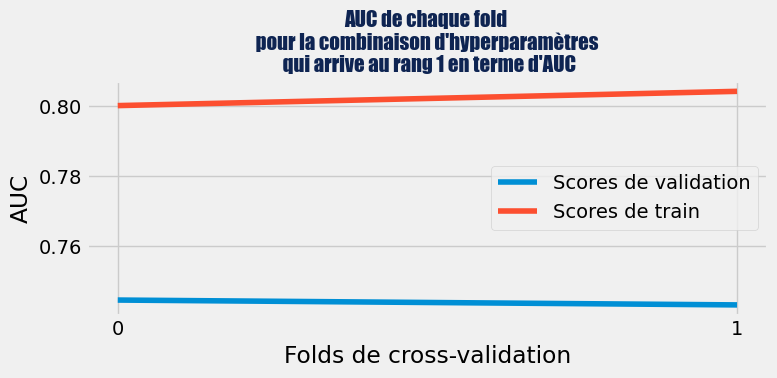

In [104]:
plot_auc_scores(best_auc_result_LGBM)

### 2.4.3 - Prédictions et métriques d'évaluation

In [105]:
result_lgbm=evaluate_model (X_train_sc, y_train, X_test_sc, y_test, best_model_lgbm)
result_lgbm

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


{'predicting_execution_time': 0.72,
 'auc_train': 0.78,
 'auc_test': 0.75,
 'optimal_threshold': 0.1,
 'f1_score_1_test': 0.27,
 'recall_1_test': 0.63,
 'accuracy_test': 0.73}

- Une AUC de 0.78 sur le train et 0.75 sur le test signifie que le modèle a une bonne capacité de discrimination entre les bons et les mauvais clients avec un léger overfitting qui reste acceptable
- Le seuil optimal de 0.1 est celui qui minimise une fonction de coût spécifique (faux négatifs coûtant 10 unités et faux positifs coûtant 1 unité, comme indiqué dans la fonction calculate_cost_threshold)
- Un rappel de 0.63 signifie que le modèle détecte correctement 63% des instances de la classe 1.
Cela indique que le modèle rate encore 37% des instances positives (faux négatifs). Bien que ce rappel soit modérément bon, il y a encore une marge d'amélioration. Le recall de la RegLog est meilleur d'un point

### 2.4.4 - Enregistrement dans ML Flow

In [ ]:
# Création d'une nouvelle expérience MLflow
mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# Démarrage de la session MLflow
with mlflow.start_run():
    # Log les hyperparameters 
    mlflow.log_params(best_params_lgbm)

    # Log les métriques
    
    mlflow.log_metric("optimal_threshold", result_lgbm['optimal_threshold'])

    mlflow.log_metric("recall_1_test", result_lgbm['recall_1_test'])
    mlflow.log_metric("f1_score_1_test", result_lgbm['f1_score_1_test'])
    mlflow.log_metric("accuracy du test", result_lgbm['accuracy_test'])
    
    mlflow.log_metric("auc_train", result_lgbm['auc_train'])
    mlflow.log_metric("auc_test", result_lgbm['auc_test'])
    
    mlflow.log_metric("temps_fit", training_execution_time)
    mlflow.log_metric("temps_predict", result_lgbm['predicting_execution_time'])

    
 
    

    # Définition d'un tag pour se rappeler l'objet de cette session
    mlflow.set_tag("Training Info", "LGBM with GridSearchCV ")

    # Infer la signature du modèle
    signature = infer_signature(X_train_sc, best_model_lgbm.predict(X_train_sc)) 
    
    # Log le model
    model_info = mlflow.sklearn.log_model(
        sk_model=best_model_lgbm.named_steps['model'], 
        artifact_path="lgbm_classifier_model", 
        signature=signature,
        input_example=input_example, 
        registered_model_name="scoring-credit-lgbm_classifier", 
    )


In [106]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     mlflow.log_params(best_params_lgbm)

#     # Log les métriques
    
#     mlflow.log_metric("optimal_threshold", result_lgbm['optimal_threshold'])

#     mlflow.log_metric("recall_1_test", result_lgbm['recall_1_test'])
#     mlflow.log_metric("f1_score_1_test", result_lgbm['f1_score_1_test'])
#     mlflow.log_metric("accuracy du test", result_lgbm['accuracy_test'])
    
#     mlflow.log_metric("auc_train", result_lgbm['auc_train'])
#     mlflow.log_metric("auc_test", result_lgbm['auc_test'])
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", result_lgbm['predicting_execution_time'])

    
 
    

#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "LGBM with GridSearchCV ")

#     # Infer the model signature
#     signature = infer_signature(X_train_sc, best_model_lgbm.predict(X_train_sc)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=best_model_lgbm.named_steps['model'], # le modèle
#         artifact_path="lgbm_classifier_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=input_example, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-lgbm_classifier", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


Registered model 'scoring-credit-lgbm_classifier' already exists. Creating a new version of this model...
2024/07/24 23:02:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: scoring-credit-lgbm_classifier, version 28
Created version '28' of model 'scoring-credit-lgbm_classifier'.


### 2.4.5 - Feature importance

In [107]:
importances = best_model_lgbm.named_steps['model'].feature_importances_
features= X_train_sc.columns

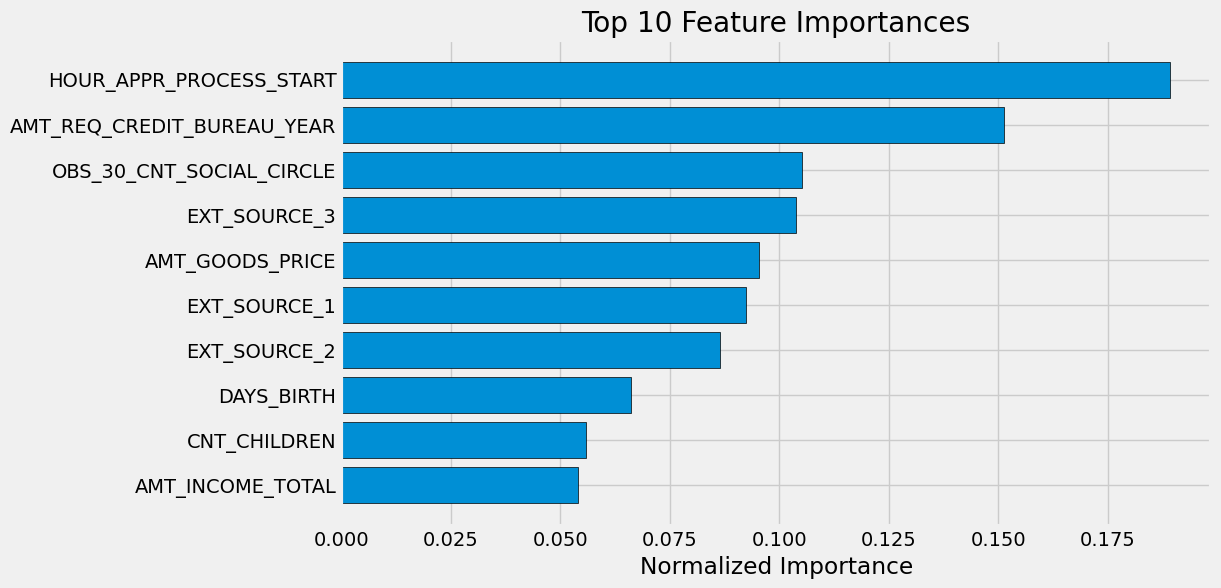

In [109]:
feature_importances_sorted=show_feature_importances(importances, features)

In [110]:
feature_importances_sorted

,feature,importance,importance_normalized
0,HOUR_APPR_PROCESS_START,315,0.189189
1,AMT_REQ_CREDIT_BUREAU_YEAR,252,0.151351
2,OBS_30_CNT_SOCIAL_CIRCLE,175,0.105105
3,EXT_SOURCE_3,173,0.103904
4,AMT_GOODS_PRICE,159,0.095495
5,EXT_SOURCE_1,154,0.092492
6,EXT_SOURCE_2,144,0.086486
7,DAYS_BIRTH,110,0.066066
8,CNT_CHILDREN,93,0.055856
9,AMT_INCOME_TOTAL,90,0.054054


Les 3 variables les + influentes pour ce modèle :
- 'HOUR_APPR_PROCESS_START' = À quelle heure environ le client a-t-il demandé le prêt ?
- 'AMT_REQ_CREDIT_BUREAU_YEAR' = Nombre de demandes de renseignements au bureau de crédit concernant le client par jour et par an (à l'exclusion des trois derniers mois précédant la demande)
- 'OBS_30_CNT_SOCIAL_CIRCLE' : nombre de fois où l' entourage  du client a eu des défauts de paiement > 30 jours après l'échéance prévue.

In [ ]:
# feature_importances_sorted.to_csv('feature_importances_sorted_lgbm_1.csv', index=False)

**CONCLUSION** :
----
- Le modèle qui parvient le mieux à distinguer les 2 classes est le LGBM avec une AUC de 0.78 sur le train et 0.75 sur le test
- C'est aussi le modèle le plus rapide en terme d'entrainement
- Le seuil optimal pour réduire le coût métier est à 0.10 avec le LGBM. A ce seuil, le modèle détecte correctement 63% des instances de la classe 1.
- Le top 3 des variables les + influentes diffèrent d'un modèle à l'autre mais on retrouve systématiquement une variable qui évoque le nombre de fois où l'entourage social du client a été enregistré comme ayant un retard de paiement.

Nous allons tenter d'améliorer le LGBM avec du feature engineering en exploitant notamment les autres datasets fournis